In [1]:
import numpy as np
import pickle
import os
#import download
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
import time
from keras.models import load_model
from keras import optimizers
import random
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


In [2]:
data_path = "data/CIFAR-10/"
data_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
img_size = 32
num_channels = 3
img_size_flat = img_size * img_size * num_channels
num_classes = 10
_num_files_train = 5
_images_per_file = 10000
_num_images_train = _num_files_train * _images_per_file

In [3]:
def _get_file_path(filename=""):
    return os.path.join(data_path, "cifar-10-batches-py/", filename)
def _unpickle(filename):
    file_path = _get_file_path(filename)
    print("Loading data: " + file_path)
    with open(file_path, mode='rb') as file:
        data = pickle.load(file, encoding='bytes')
    return data
def _convert_images(raw):
    raw_float = np.array(raw, dtype=float)/255.0
    images = raw_float.reshape([-1, num_channels, img_size, img_size])
    images = images.transpose([0, 2, 3, 1])

    return images
def _load_data(filename):
    data = _unpickle(filename)
    raw_images = data[b'data']
    cls = np.array(data[b'labels'])
    images = _convert_images(raw_images)

    return images, cls
def load_class_names():

    # Load the class-names from the pickled file.
    raw = _unpickle(filename="batches.meta")[b'label_names']

    # Convert from binary strings.
    names = [x.decode('utf-8') for x in raw]

    return names
def one_hot_encoded(class_numbers, num_classes=None):
    if num_classes is None:
        num_classes = np.max(class_numbers) + 1

    return np.eye(num_classes, dtype=float)[class_numbers]
def load_training_data():
    images = np.zeros(shape=[_num_images_train, img_size, img_size, num_channels], dtype=float)
    cls = np.zeros(shape=[_num_images_train], dtype=int)

    begin = 0

    for i in range(_num_files_train):
       
        images_batch, cls_batch = _load_data(filename="data_batch_" + str(i + 1))
        num_images = len(images_batch)
        end = begin + num_images
        images[begin:end, :] = images_batch
        cls[begin:end] = cls_batch
        begin = end

    return images, cls, one_hot_encoded(class_numbers=cls, num_classes=num_classes)
def load_test_data():
    images, cls = _load_data(filename="test_batch")

    return images, cls, one_hot_encoded(class_numbers=cls, num_classes=num_classes)

In [4]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

# Extracting the training and the test data

# Printing the class labels present in the data set

In [6]:
class_names = load_class_names()
print(class_names)

Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# Visualizing one of the images

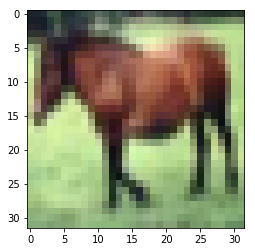

In [7]:
plt.imshow(images_train[7], interpolation = 'nearest') 

# Distribution of the Training and Test data under each class

In [8]:
digit_train, counts_train = np.unique(cls_train, return_counts = True)

distribution_train = dict(zip(class_names, counts_train))
print(distribution_train )

{'airplane': 5000, 'automobile': 5000, 'bird': 5000, 'cat': 5000, 'deer': 5000, 'dog': 5000, 'frog': 5000, 'horse': 5000, 'ship': 5000, 'truck': 5000}


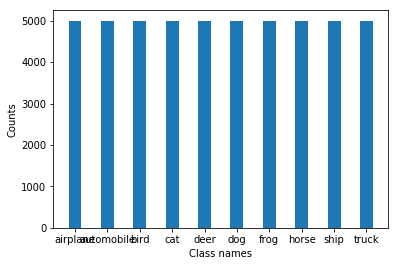

In [9]:
plt.bar(list(distribution_train.keys()),distribution_train.values(),width =0.4)
plt.xlabel('Class names')
plt.ylabel('Counts')
plt.show()

In [10]:
digit_test, counts_test = np.unique(test_cls, return_counts = True)

distribution_test = dict(zip(class_names, counts_test))
print(distribution_test)

{'airplane': 1000, 'automobile': 1000, 'bird': 1000, 'cat': 1000, 'deer': 1000, 'dog': 1000, 'frog': 1000, 'horse': 1000, 'ship': 1000, 'truck': 1000}


# Visualizing Images randomly with Class Names

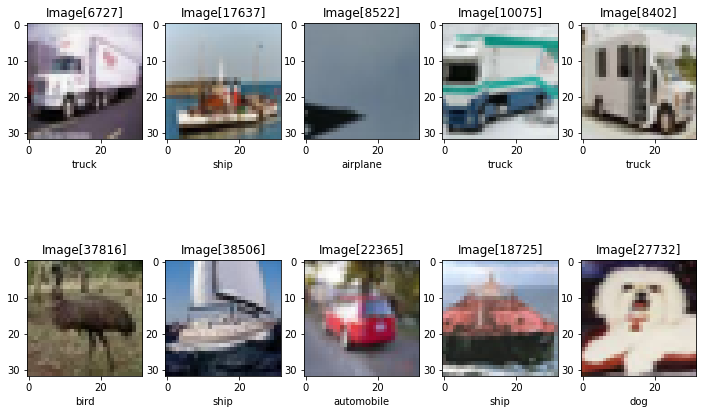

In [11]:
fig_object, ax_object = plt.subplots(2, 5, figsize=(12,8))
ax_object = ax_object.reshape(10,)
for i in range(len(ax_object)):
    ax = ax_object[i]
    rn = random.randint(1,40000)
    ax.imshow(images_train[rn], cmap = plt.cm.binary, interpolation = 'nearest')
    xlabel = "{0}".format(class_names[cls_train[rn]])
    title = "Image[{0}]".format(rn)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
plt.show()


# Cross Validation - Splitting Training data into Training and Validation

In [12]:
from sklearn.model_selection import train_test_split
X_train1, X_val1, Y_train, Y_val = train_test_split(images_train, labels_train, test_size=1/12, random_state=42)

In [13]:
X_train1.shape

(45833, 32, 32, 3)

In [14]:
print(X_train1.size)

140798976


# Normalization of the Training and Validation data

In [15]:
X_train_unscaled =  np.resize(X_train1,(45833,3072))

In [16]:
X_val_unscaled = np.resize(X_val1,(4167,3072))

In [17]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_unscaled.astype(np.float32))

In [18]:
X_val = scaler.fit_transform(X_val_unscaled.astype(np.float32))

In [19]:
X_train

array([[-0.09209613, -0.12551029, -0.05773713, ..., -0.6425603 ,
        -0.94060159, -0.79485917],
       [ 1.44622958,  1.28704798,  1.16037238, ...,  0.29628146,
         0.16021036,  0.17357734],
       [-1.30369782, -1.45578361, -1.32556558, ...,  1.63528514,
         1.72368217,  1.86834121],
       ..., 
       [-0.32352564,  0.14877294,  0.7626223 , ..., -1.47366619,
        -1.53089201, -1.21855021],
       [ 1.6912725 ,  1.62990189,  1.52083325, ..., -0.85803217,
        -0.98846292, -0.809991  ],
       [ 0.76555449,  0.94419402,  1.3343879 , ..., -0.71951455,
        -0.39817256, -0.12905906]], dtype=float32)

# Training the Model with ReLU as the activation function for different Neurons in one Hidden Layer

C:\Users\Lavanya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=10)`
  
C:\Users\Lavanya\Anaconda3\lib\site-packages\keras\models.py:844: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 45833 samples, validate on 4167 samples
Epoch 1/200
45833/45833 [==============================] - 3s - loss: 0.0970 - acc: 0.1463 - val_loss: 0.0922 - val_acc: 0.1817
Epoch 2/200
45833/45833 [==============================] - 2s - loss: 0.0907 - acc: 0.2005 - val_loss: 0.0885 - val_acc: 0.2275
Epoch 3/200
45833/45833 [==============================] - 3s - loss: 0.0874 - acc: 0.2392 - val_loss: 0.0861 - val_acc: 0.2549
Epoch 4/200
45833/45833 [==============================] - 2s - loss: 0.0851 - acc: 0.2643 - val_loss: 0.0844 - val_acc: 0.2753
Epoch 5/200
45833/45833 [==============================] - 2s - loss: 0.0834 - acc: 0.2865 - val_loss: 0.0830 - val_acc: 0.2928
Epoch 6/200
45833/45833 [==============================] - 2s - loss: 0.0820 - acc: 0.3067 - val_loss: 0.0819 - val_acc: 0.3050
Epoch 7/200
45833/45833 [==============================] - 2s - loss: 0.0809 - acc: 0.3222 - val_loss: 0.0810 - val_acc: 0.3180
Epoch 8/200
45833/45833 [==============================

45833/45833 [==============================] - 2s - loss: 0.0641 - acc: 0.5086 - val_loss: 0.0690 - val_acc: 0.4504
Epoch 128/200
45833/45833 [==============================] - 2s - loss: 0.0640 - acc: 0.5097 - val_loss: 0.0689 - val_acc: 0.4500
Epoch 129/200
45833/45833 [==============================] - 2s - loss: 0.0640 - acc: 0.5101 - val_loss: 0.0689 - val_acc: 0.4485
Epoch 130/200
45833/45833 [==============================] - 2s - loss: 0.0640 - acc: 0.5098 - val_loss: 0.0690 - val_acc: 0.4516
Epoch 131/200
45833/45833 [==============================] - 2s - loss: 0.0639 - acc: 0.5099 - val_loss: 0.0689 - val_acc: 0.4516
Epoch 132/200
45833/45833 [==============================] - 2s - loss: 0.0639 - acc: 0.5110 - val_loss: 0.0689 - val_acc: 0.4504
Epoch 133/200
45833/45833 [==============================] - 2s - loss: 0.0638 - acc: 0.5117 - val_loss: 0.0689 - val_acc: 0.4524
Epoch 134/200
45833/45833 [==============================] - 2s - loss: 0.0638 - acc: 0.5109 - val_loss:

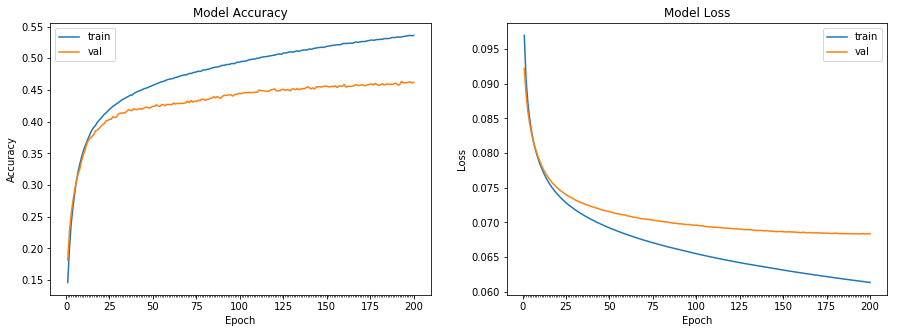

Train on 45833 samples, validate on 4167 samples
Epoch 1/200
45833/45833 [==============================] - 3s - loss: 0.0949 - acc: 0.1537 - val_loss: 0.0901 - val_acc: 0.2071
Epoch 2/200
45833/45833 [==============================] - 3s - loss: 0.0876 - acc: 0.2384 - val_loss: 0.0861 - val_acc: 0.2628
Epoch 3/200
45833/45833 [==============================] - 3s - loss: 0.0844 - acc: 0.2772 - val_loss: 0.0836 - val_acc: 0.2930
Epoch 4/200
45833/45833 [==============================] - 3s - loss: 0.0822 - acc: 0.3012 - val_loss: 0.0819 - val_acc: 0.3041
Epoch 5/200
45833/45833 [==============================] - 3s - loss: 0.0807 - acc: 0.3208 - val_loss: 0.0807 - val_acc: 0.3194
Epoch 6/200
45833/45833 [==============================] - 3s - loss: 0.0795 - acc: 0.3346 - val_loss: 0.0797 - val_acc: 0.3271
Epoch 7/200
45833/45833 [==============================] - 3s - loss: 0.0785 - acc: 0.3456 - val_loss: 0.0789 - val_acc: 0.3353
Epoch 8/200
45833/45833 [==============================

45833/45833 [==============================] - 3s - loss: 0.0603 - acc: 0.5432 - val_loss: 0.0679 - val_acc: 0.4567
Epoch 128/200
45833/45833 [==============================] - 3s - loss: 0.0603 - acc: 0.5442 - val_loss: 0.0679 - val_acc: 0.4567
Epoch 129/200
45833/45833 [==============================] - 3s - loss: 0.0602 - acc: 0.5445 - val_loss: 0.0678 - val_acc: 0.4579
Epoch 130/200
45833/45833 [==============================] - 3s - loss: 0.0602 - acc: 0.5461 - val_loss: 0.0678 - val_acc: 0.4569
Epoch 131/200
45833/45833 [==============================] - 3s - loss: 0.0601 - acc: 0.5459 - val_loss: 0.0678 - val_acc: 0.4574
Epoch 132/200
45833/45833 [==============================] - 3s - loss: 0.0600 - acc: 0.5465 - val_loss: 0.0678 - val_acc: 0.4560
Epoch 133/200
45833/45833 [==============================] - 3s - loss: 0.0600 - acc: 0.5471 - val_loss: 0.0678 - val_acc: 0.4574
Epoch 134/200
45833/45833 [==============================] - 3s - loss: 0.0599 - acc: 0.5475 - val_loss:

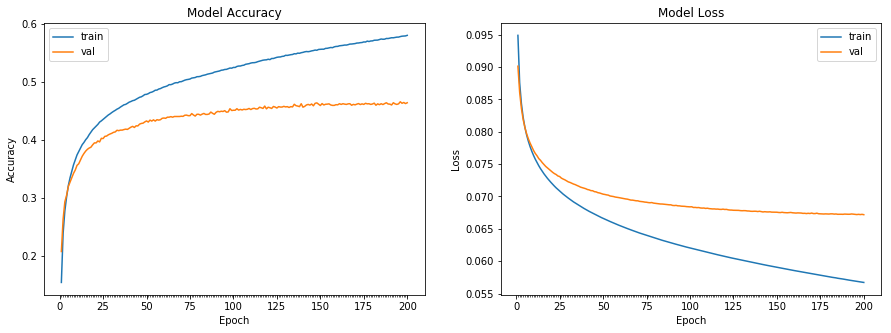

Train on 45833 samples, validate on 4167 samples
Epoch 1/200
45833/45833 [==============================] - 6s - loss: 0.0947 - acc: 0.1775 - val_loss: 0.0906 - val_acc: 0.2196
Epoch 2/200
45833/45833 [==============================] - 5s - loss: 0.0884 - acc: 0.2429 - val_loss: 0.0866 - val_acc: 0.2604
Epoch 3/200
45833/45833 [==============================] - 5s - loss: 0.0851 - acc: 0.2774 - val_loss: 0.0840 - val_acc: 0.2851
Epoch 4/200
45833/45833 [==============================] - 5s - loss: 0.0828 - acc: 0.3043 - val_loss: 0.0822 - val_acc: 0.3069
Epoch 5/200
45833/45833 [==============================] - 5s - loss: 0.0811 - acc: 0.3236 - val_loss: 0.0808 - val_acc: 0.3204
Epoch 6/200
45833/45833 [==============================] - 5s - loss: 0.0798 - acc: 0.3377 - val_loss: 0.0797 - val_acc: 0.3357
Epoch 7/200
45833/45833 [==============================] - 5s - loss: 0.0787 - acc: 0.3508 - val_loss: 0.0788 - val_acc: 0.3429
Epoch 8/200
45833/45833 [==============================

45833/45833 [==============================] - 5s - loss: 0.0573 - acc: 0.5770 - val_loss: 0.0660 - val_acc: 0.4850
Epoch 128/200
45833/45833 [==============================] - 5s - loss: 0.0572 - acc: 0.5777 - val_loss: 0.0660 - val_acc: 0.4821
Epoch 129/200
45833/45833 [==============================] - 5s - loss: 0.0572 - acc: 0.5773 - val_loss: 0.0660 - val_acc: 0.4814
Epoch 130/200
45833/45833 [==============================] - 5s - loss: 0.0571 - acc: 0.5793 - val_loss: 0.0659 - val_acc: 0.4828
Epoch 131/200
45833/45833 [==============================] - 5s - loss: 0.0570 - acc: 0.5789 - val_loss: 0.0660 - val_acc: 0.4828
Epoch 132/200
45833/45833 [==============================] - 5s - loss: 0.0570 - acc: 0.5805 - val_loss: 0.0659 - val_acc: 0.4864
Epoch 133/200
45833/45833 [==============================] - 5s - loss: 0.0569 - acc: 0.5817 - val_loss: 0.0659 - val_acc: 0.4845
Epoch 134/200
45833/45833 [==============================] - 5s - loss: 0.0568 - acc: 0.5819 - val_loss:

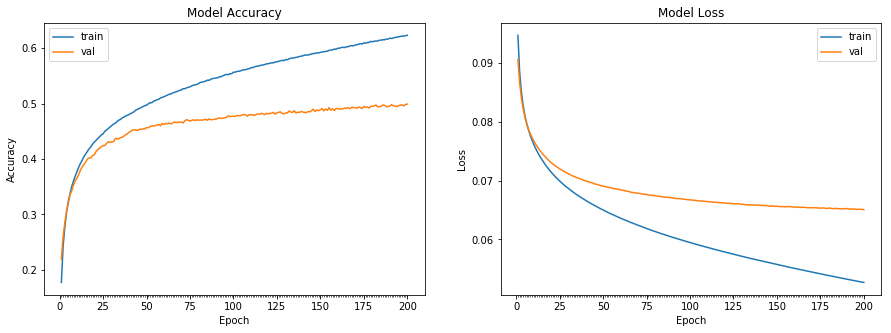

Train on 45833 samples, validate on 4167 samples
Epoch 1/200
45833/45833 [==============================] - 9s - loss: 0.0951 - acc: 0.1730 - val_loss: 0.0901 - val_acc: 0.2249
Epoch 2/200
45833/45833 [==============================] - 9s - loss: 0.0878 - acc: 0.2428 - val_loss: 0.0861 - val_acc: 0.2700
Epoch 3/200
45833/45833 [==============================] - 9s - loss: 0.0845 - acc: 0.2812 - val_loss: 0.0835 - val_acc: 0.3009
Epoch 4/200
45833/45833 [==============================] - 9s - loss: 0.0821 - acc: 0.3074 - val_loss: 0.0816 - val_acc: 0.3170
Epoch 5/200
45833/45833 [==============================] - 9s - loss: 0.0804 - acc: 0.3270 - val_loss: 0.0802 - val_acc: 0.3331
Epoch 6/200
45833/45833 [==============================] - 9s - loss: 0.0789 - acc: 0.3430 - val_loss: 0.0791 - val_acc: 0.3439
Epoch 7/200
45833/45833 [==============================] - 9s - loss: 0.0777 - acc: 0.3567 - val_loss: 0.0781 - val_acc: 0.3523
Epoch 8/200
45833/45833 [==============================

45833/45833 [==============================] - 9s - loss: 0.0550 - acc: 0.5976 - val_loss: 0.0651 - val_acc: 0.4900
Epoch 127/200
45833/45833 [==============================] - 9s - loss: 0.0549 - acc: 0.5991 - val_loss: 0.0651 - val_acc: 0.4912
Epoch 128/200
45833/45833 [==============================] - 9s - loss: 0.0548 - acc: 0.6000 - val_loss: 0.0650 - val_acc: 0.4905
Epoch 129/200
45833/45833 [==============================] - 9s - loss: 0.0547 - acc: 0.6009 - val_loss: 0.0650 - val_acc: 0.4920
Epoch 130/200
45833/45833 [==============================] - 9s - loss: 0.0547 - acc: 0.6017 - val_loss: 0.0650 - val_acc: 0.4934
Epoch 131/200
45833/45833 [==============================] - 9s - loss: 0.0546 - acc: 0.6022 - val_loss: 0.0650 - val_acc: 0.4944
Epoch 132/200
45833/45833 [==============================] - 9s - loss: 0.0545 - acc: 0.6025 - val_loss: 0.0649 - val_acc: 0.4922
Epoch 133/200
45833/45833 [==============================] - 9s - loss: 0.0544 - acc: 0.6037 - val_loss:

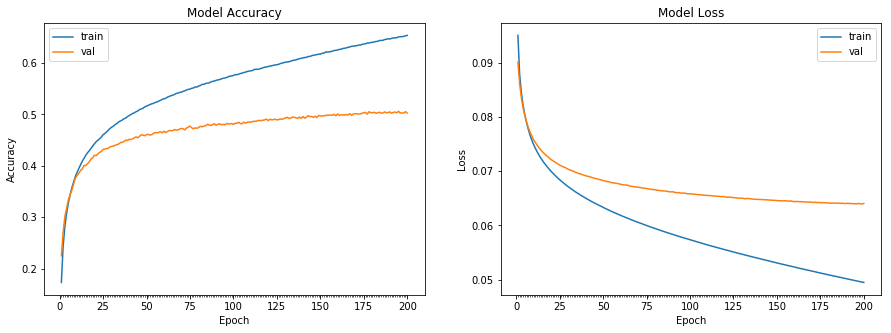

Train on 45833 samples, validate on 4167 samples
Epoch 1/200
45833/45833 [==============================] - 17s - loss: 0.0931 - acc: 0.1692 - val_loss: 0.0890 - val_acc: 0.2253
Epoch 2/200
45833/45833 [==============================] - 17s - loss: 0.0861 - acc: 0.2563 - val_loss: 0.0847 - val_acc: 0.2781
Epoch 3/200
45833/45833 [==============================] - 17s - loss: 0.0824 - acc: 0.3033 - val_loss: 0.0819 - val_acc: 0.3149
Epoch 4/200
45833/45833 [==============================] - 17s - loss: 0.0800 - acc: 0.3328 - val_loss: 0.0801 - val_acc: 0.3314
Epoch 5/200
45833/45833 [==============================] - 17s - loss: 0.0783 - acc: 0.3537 - val_loss: 0.0787 - val_acc: 0.3468
Epoch 6/200
45833/45833 [==============================] - 17s - loss: 0.0769 - acc: 0.3686 - val_loss: 0.0777 - val_acc: 0.3585
Epoch 7/200
45833/45833 [==============================] - 17s - loss: 0.0758 - acc: 0.3828 - val_loss: 0.0768 - val_acc: 0.3681
Epoch 8/200
45833/45833 [=======================

45833/45833 [==============================] - 18s - loss: 0.0530 - acc: 0.6199 - val_loss: 0.0643 - val_acc: 0.4932
Epoch 126/200
45833/45833 [==============================] - 17s - loss: 0.0529 - acc: 0.6217 - val_loss: 0.0643 - val_acc: 0.4941
Epoch 127/200
45833/45833 [==============================] - 17s - loss: 0.0528 - acc: 0.6220 - val_loss: 0.0643 - val_acc: 0.4965
Epoch 128/200
45833/45833 [==============================] - 17s - loss: 0.0527 - acc: 0.6236 - val_loss: 0.0643 - val_acc: 0.4953
Epoch 129/200
45833/45833 [==============================] - 17s - loss: 0.0526 - acc: 0.6241 - val_loss: 0.0643 - val_acc: 0.4960
Epoch 130/200
45833/45833 [==============================] - 17s - loss: 0.0525 - acc: 0.6256 - val_loss: 0.0642 - val_acc: 0.4977
Epoch 131/200
45833/45833 [==============================] - 17s - loss: 0.0524 - acc: 0.6258 - val_loss: 0.0642 - val_acc: 0.4965
Epoch 132/200
45833/45833 [==============================] - 17s - loss: 0.0524 - acc: 0.6271 - v

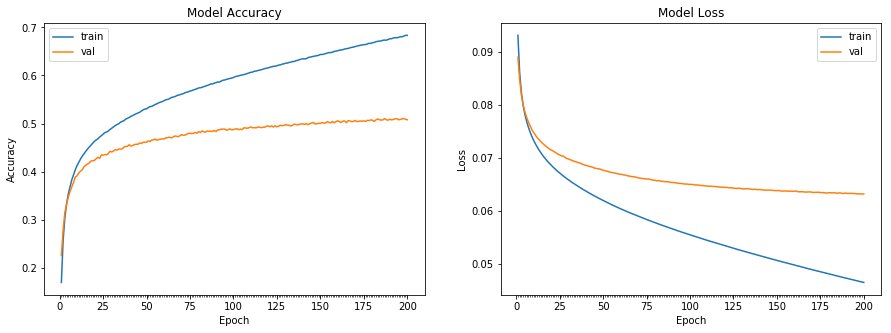

Train on 45833 samples, validate on 4167 samples
Epoch 1/200
45833/45833 [==============================] - 33s - loss: 0.0918 - acc: 0.1757 - val_loss: 0.0860 - val_acc: 0.2486
Epoch 2/200
45833/45833 [==============================] - 32s - loss: 0.0837 - acc: 0.2762 - val_loss: 0.0816 - val_acc: 0.3065
Epoch 3/200
45833/45833 [==============================] - 32s - loss: 0.0803 - acc: 0.3249 - val_loss: 0.0791 - val_acc: 0.3384
Epoch 4/200
45833/45833 [==============================] - 32s - loss: 0.0782 - acc: 0.3496 - val_loss: 0.0775 - val_acc: 0.3588
Epoch 5/200
45833/45833 [==============================] - 33s - loss: 0.0767 - acc: 0.3688 - val_loss: 0.0764 - val_acc: 0.3746
Epoch 6/200
45833/45833 [==============================] - 33s - loss: 0.0755 - acc: 0.3829 - val_loss: 0.0754 - val_acc: 0.3890
Epoch 7/200
45833/45833 [==============================] - 33s - loss: 0.0746 - acc: 0.3936 - val_loss: 0.0747 - val_acc: 0.3957
Epoch 8/200
45833/45833 [=======================

45833/45833 [==============================] - 35s - loss: 0.0509 - acc: 0.6431 - val_loss: 0.0636 - val_acc: 0.5025
Epoch 126/200
45833/45833 [==============================] - 32s - loss: 0.0508 - acc: 0.6435 - val_loss: 0.0636 - val_acc: 0.5020
Epoch 127/200
45833/45833 [==============================] - 33s - loss: 0.0507 - acc: 0.6460 - val_loss: 0.0636 - val_acc: 0.5013
Epoch 128/200
45833/45833 [==============================] - 33s - loss: 0.0506 - acc: 0.6463 - val_loss: 0.0635 - val_acc: 0.5004
Epoch 129/200
45833/45833 [==============================] - 32s - loss: 0.0505 - acc: 0.6466 - val_loss: 0.0635 - val_acc: 0.5025
Epoch 130/200
45833/45833 [==============================] - 33s - loss: 0.0504 - acc: 0.6485 - val_loss: 0.0635 - val_acc: 0.5001
Epoch 131/200
45833/45833 [==============================] - 33s - loss: 0.0503 - acc: 0.6487 - val_loss: 0.0635 - val_acc: 0.5020
Epoch 132/200
45833/45833 [==============================] - 33s - loss: 0.0502 - acc: 0.6504 - v

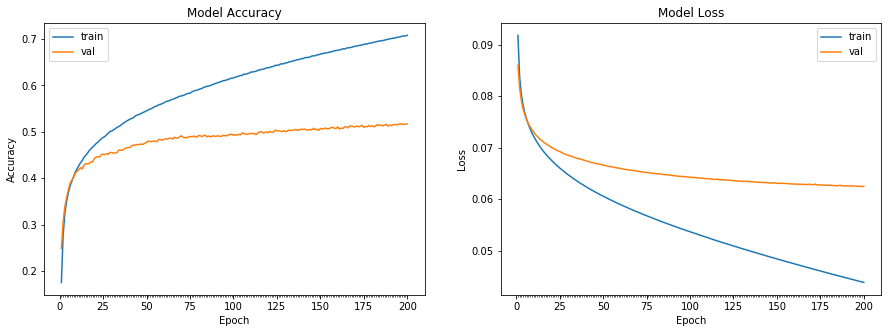

Train on 45833 samples, validate on 4167 samples
Epoch 1/200
45833/45833 [==============================] - 90s - loss: 0.0871 - acc: 0.2213 - val_loss: 0.0834 - val_acc: 0.2796
Epoch 2/200
45833/45833 [==============================] - 89s - loss: 0.0809 - acc: 0.3143 - val_loss: 0.0797 - val_acc: 0.3276
Epoch 3/200
45833/45833 [==============================] - 89s - loss: 0.0780 - acc: 0.3532 - val_loss: 0.0776 - val_acc: 0.3564
Epoch 4/200
45833/45833 [==============================] - 90s - loss: 0.0761 - acc: 0.3760 - val_loss: 0.0760 - val_acc: 0.3760
Epoch 5/200
45833/45833 [==============================] - 90s - loss: 0.0746 - acc: 0.3939 - val_loss: 0.0749 - val_acc: 0.3880
Epoch 6/200
45833/45833 [==============================] - 90s - loss: 0.0735 - acc: 0.4076 - val_loss: 0.0740 - val_acc: 0.3998
Epoch 7/200
45833/45833 [==============================] - 90s - loss: 0.0726 - acc: 0.4181 - val_loss: 0.0732 - val_acc: 0.4084
Epoch 8/200
45833/45833 [=======================

45833/45833 [==============================] - 89s - loss: 0.0475 - acc: 0.6793 - val_loss: 0.0625 - val_acc: 0.5162
Epoch 126/200
45833/45833 [==============================] - 88s - loss: 0.0474 - acc: 0.6805 - val_loss: 0.0625 - val_acc: 0.5152
Epoch 127/200
45833/45833 [==============================] - 88s - loss: 0.0473 - acc: 0.6807 - val_loss: 0.0624 - val_acc: 0.5155
Epoch 128/200
45833/45833 [==============================] - 88s - loss: 0.0472 - acc: 0.6817 - val_loss: 0.0624 - val_acc: 0.5155
Epoch 129/200
45833/45833 [==============================] - 90s - loss: 0.0470 - acc: 0.6830 - val_loss: 0.0624 - val_acc: 0.5152
Epoch 130/200
45833/45833 [==============================] - 89s - loss: 0.0469 - acc: 0.6849 - val_loss: 0.0623 - val_acc: 0.5174
Epoch 131/200
45833/45833 [==============================] - 88s - loss: 0.0468 - acc: 0.6861 - val_loss: 0.0623 - val_acc: 0.5155
Epoch 132/200
45833/45833 [==============================] - 89s - loss: 0.0467 - acc: 0.6866 - v

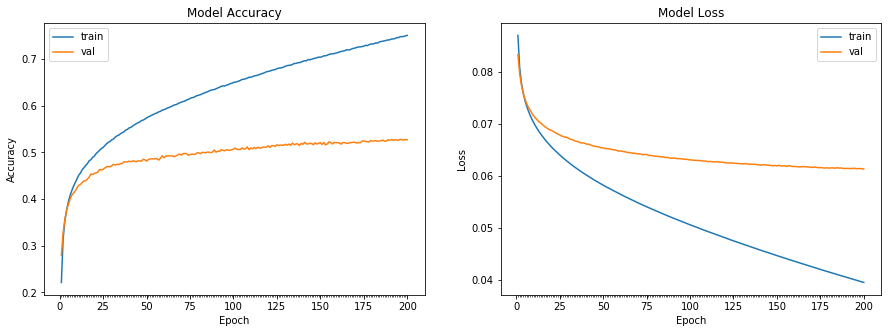

In [20]:
hist=[];time_relu=[]
no_neurons=[32,64,128,256,512,1024,3072]
for i in range(0,len(no_neurons)):
    hidden_neurons = no_neurons[i]
    model = Sequential()
    model.add(Dense(hidden_neurons, input_dim=3072))
    model.add(Activation("relu"))
    model.add(Dense(output_dim=10))
    model.add(Activation("softmax"))
    sgd = optimizers.SGD(lr=0.01)
    model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])
    start = time.time()
    model_info_relu=model.fit(X_train, Y_train, batch_size=100,nb_epoch=200,validation_data=(X_val,Y_val))
    end = time.time()
    hist.extend([model_info_relu.history['acc']])
    hist.extend([model_info_relu.history['loss']])
    hist.extend([model_info_relu.history['val_acc']])
    hist.extend([model_info_relu.history['val_loss']])
    time_relu.extend([(end - start)])
    string = "model_info_relu"+str(hidden_neurons)
    model.save(string)  
    print("Model took %0.2f seconds to train" %(end - start))
    plot_model_history(model_info_relu)

# Training the Model with Sigmoid as the activation function for different Neurons in one Hidden Layer

C:\Users\Lavanya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=10)`
  
C:\Users\Lavanya\Anaconda3\lib\site-packages\keras\models.py:844: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 45833 samples, validate on 4167 samples
Epoch 1/200
45833/45833 [==============================] - 2s - loss: 0.0916 - acc: 0.1249 - val_loss: 0.0907 - val_acc: 0.1377
Epoch 2/200
45833/45833 [==============================] - 2s - loss: 0.0898 - acc: 0.1574 - val_loss: 0.0893 - val_acc: 0.1713
Epoch 3/200
45833/45833 [==============================] - 2s - loss: 0.0886 - acc: 0.1893 - val_loss: 0.0882 - val_acc: 0.1975
Epoch 4/200
45833/45833 [==============================] - 2s - loss: 0.0877 - acc: 0.2095 - val_loss: 0.0874 - val_acc: 0.2133
Epoch 5/200
45833/45833 [==============================] - 2s - loss: 0.0869 - acc: 0.2241 - val_loss: 0.0868 - val_acc: 0.2241
Epoch 6/200
45833/45833 [==============================] - 2s - loss: 0.0863 - acc: 0.2354 - val_loss: 0.0863 - val_acc: 0.2352
Epoch 7/200
45833/45833 [==============================] - 2s - loss: 0.0858 - acc: 0.2471 - val_loss: 0.0858 - val_acc: 0.2426
Epoch 8/200
45833/45833 [==============================

45833/45833 [==============================] - 2s - loss: 0.0750 - acc: 0.4016 - val_loss: 0.0757 - val_acc: 0.3890
Epoch 128/200
45833/45833 [==============================] - 2s - loss: 0.0750 - acc: 0.4019 - val_loss: 0.0757 - val_acc: 0.3890
Epoch 129/200
45833/45833 [==============================] - 2s - loss: 0.0749 - acc: 0.4022 - val_loss: 0.0757 - val_acc: 0.3878
Epoch 130/200
45833/45833 [==============================] - 2s - loss: 0.0749 - acc: 0.4025 - val_loss: 0.0757 - val_acc: 0.3885
Epoch 131/200
45833/45833 [==============================] - 2s - loss: 0.0749 - acc: 0.4030 - val_loss: 0.0756 - val_acc: 0.3883
Epoch 132/200
45833/45833 [==============================] - 2s - loss: 0.0748 - acc: 0.4035 - val_loss: 0.0756 - val_acc: 0.3888
Epoch 133/200
45833/45833 [==============================] - 2s - loss: 0.0748 - acc: 0.4032 - val_loss: 0.0756 - val_acc: 0.3888
Epoch 134/200
45833/45833 [==============================] - 2s - loss: 0.0748 - acc: 0.4037 - val_loss:

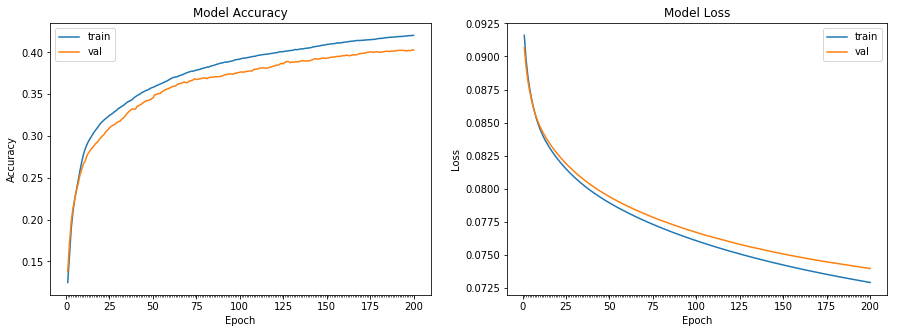

Train on 45833 samples, validate on 4167 samples
Epoch 1/200
45833/45833 [==============================] - 3s - loss: 0.0950 - acc: 0.1025 - val_loss: 0.0924 - val_acc: 0.1126
Epoch 2/200
45833/45833 [==============================] - 3s - loss: 0.0909 - acc: 0.1372 - val_loss: 0.0900 - val_acc: 0.1572
Epoch 3/200
45833/45833 [==============================] - 3s - loss: 0.0890 - acc: 0.1767 - val_loss: 0.0885 - val_acc: 0.1903
Epoch 4/200
45833/45833 [==============================] - 3s - loss: 0.0876 - acc: 0.2065 - val_loss: 0.0874 - val_acc: 0.2172
Epoch 5/200
45833/45833 [==============================] - 3s - loss: 0.0866 - acc: 0.2320 - val_loss: 0.0864 - val_acc: 0.2361
Epoch 6/200
45833/45833 [==============================] - 3s - loss: 0.0857 - acc: 0.2555 - val_loss: 0.0857 - val_acc: 0.2594
Epoch 7/200
45833/45833 [==============================] - 3s - loss: 0.0850 - acc: 0.2718 - val_loss: 0.0850 - val_acc: 0.2748
Epoch 8/200
45833/45833 [==============================

45833/45833 [==============================] - 3s - loss: 0.0734 - acc: 0.4146 - val_loss: 0.0742 - val_acc: 0.3991
Epoch 128/200
45833/45833 [==============================] - 3s - loss: 0.0734 - acc: 0.4150 - val_loss: 0.0742 - val_acc: 0.3986
Epoch 129/200
45833/45833 [==============================] - 3s - loss: 0.0734 - acc: 0.4154 - val_loss: 0.0742 - val_acc: 0.3998
Epoch 130/200
45833/45833 [==============================] - 3s - loss: 0.0733 - acc: 0.4155 - val_loss: 0.0741 - val_acc: 0.4003
Epoch 131/200
45833/45833 [==============================] - 3s - loss: 0.0733 - acc: 0.4161 - val_loss: 0.0741 - val_acc: 0.4003
Epoch 132/200
45833/45833 [==============================] - 3s - loss: 0.0733 - acc: 0.4161 - val_loss: 0.0741 - val_acc: 0.4010
Epoch 133/200
45833/45833 [==============================] - 3s - loss: 0.0732 - acc: 0.4162 - val_loss: 0.0741 - val_acc: 0.4020
Epoch 134/200
45833/45833 [==============================] - 3s - loss: 0.0732 - acc: 0.4166 - val_loss:

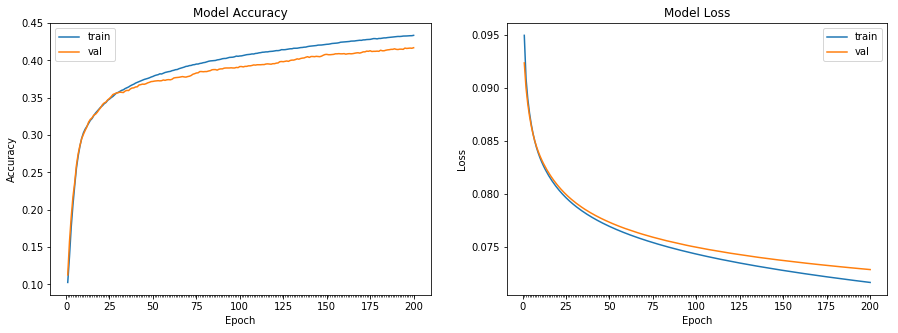

Train on 45833 samples, validate on 4167 samples
Epoch 1/200
45833/45833 [==============================] - 5s - loss: 0.0921 - acc: 0.1027 - val_loss: 0.0910 - val_acc: 0.1265
Epoch 2/200
45833/45833 [==============================] - 5s - loss: 0.0900 - acc: 0.1445 - val_loss: 0.0893 - val_acc: 0.1593
Epoch 3/200
45833/45833 [==============================] - 5s - loss: 0.0884 - acc: 0.1840 - val_loss: 0.0878 - val_acc: 0.1932
Epoch 4/200
45833/45833 [==============================] - 5s - loss: 0.0870 - acc: 0.2188 - val_loss: 0.0867 - val_acc: 0.2249
Epoch 5/200
45833/45833 [==============================] - 5s - loss: 0.0859 - acc: 0.2382 - val_loss: 0.0857 - val_acc: 0.2397
Epoch 6/200
45833/45833 [==============================] - 5s - loss: 0.0849 - acc: 0.2560 - val_loss: 0.0849 - val_acc: 0.2525
Epoch 7/200
45833/45833 [==============================] - 5s - loss: 0.0842 - acc: 0.2720 - val_loss: 0.0842 - val_acc: 0.2721
Epoch 8/200
45833/45833 [==============================

45833/45833 [==============================] - 5s - loss: 0.0725 - acc: 0.4231 - val_loss: 0.0737 - val_acc: 0.4084
Epoch 128/200
45833/45833 [==============================] - 5s - loss: 0.0725 - acc: 0.4236 - val_loss: 0.0737 - val_acc: 0.4084
Epoch 129/200
45833/45833 [==============================] - 5s - loss: 0.0725 - acc: 0.4237 - val_loss: 0.0737 - val_acc: 0.4092
Epoch 130/200
45833/45833 [==============================] - 5s - loss: 0.0724 - acc: 0.4245 - val_loss: 0.0737 - val_acc: 0.4101
Epoch 131/200
45833/45833 [==============================] - 5s - loss: 0.0724 - acc: 0.4244 - val_loss: 0.0736 - val_acc: 0.4113
Epoch 132/200
45833/45833 [==============================] - 5s - loss: 0.0724 - acc: 0.4248 - val_loss: 0.0736 - val_acc: 0.4108
Epoch 133/200
45833/45833 [==============================] - 5s - loss: 0.0723 - acc: 0.4248 - val_loss: 0.0736 - val_acc: 0.4118
Epoch 134/200
45833/45833 [==============================] - 5s - loss: 0.0723 - acc: 0.4256 - val_loss:

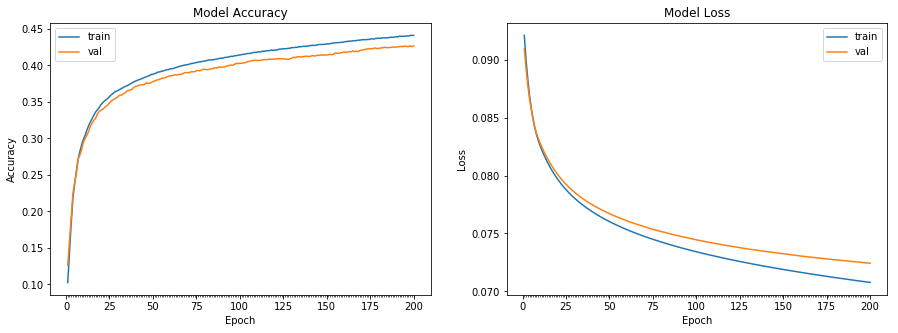

Train on 45833 samples, validate on 4167 samples
Epoch 1/200
45833/45833 [==============================] - 9s - loss: 0.0938 - acc: 0.1102 - val_loss: 0.0912 - val_acc: 0.1452
Epoch 2/200
45833/45833 [==============================] - 9s - loss: 0.0903 - acc: 0.1585 - val_loss: 0.0889 - val_acc: 0.1951
Epoch 3/200
45833/45833 [==============================] - 9s - loss: 0.0884 - acc: 0.2045 - val_loss: 0.0875 - val_acc: 0.2215
Epoch 4/200
45833/45833 [==============================] - 9s - loss: 0.0872 - acc: 0.2262 - val_loss: 0.0865 - val_acc: 0.2381
Epoch 5/200
45833/45833 [==============================] - 9s - loss: 0.0862 - acc: 0.2400 - val_loss: 0.0855 - val_acc: 0.2491
Epoch 6/200
45833/45833 [==============================] - 9s - loss: 0.0852 - acc: 0.2555 - val_loss: 0.0845 - val_acc: 0.2676
Epoch 7/200
45833/45833 [==============================] - 9s - loss: 0.0842 - acc: 0.2738 - val_loss: 0.0837 - val_acc: 0.2839
Epoch 8/200
45833/45833 [==============================

45833/45833 [==============================] - 9s - loss: 0.0746 - acc: 0.4020 - val_loss: 0.0751 - val_acc: 0.3900
Epoch 65/200
45833/45833 [==============================] - 9s - loss: 0.0745 - acc: 0.4026 - val_loss: 0.0751 - val_acc: 0.3914
Epoch 66/200
45833/45833 [==============================] - 9s - loss: 0.0745 - acc: 0.4035 - val_loss: 0.0750 - val_acc: 0.3924
Epoch 67/200
45833/45833 [==============================] - 9s - loss: 0.0744 - acc: 0.4044 - val_loss: 0.0750 - val_acc: 0.3926
Epoch 68/200
45833/45833 [==============================] - 9s - loss: 0.0743 - acc: 0.4049 - val_loss: 0.0749 - val_acc: 0.3924
Epoch 69/200
45833/45833 [==============================] - 9s - loss: 0.0743 - acc: 0.4056 - val_loss: 0.0749 - val_acc: 0.3938
Epoch 70/200
45833/45833 [==============================] - 9s - loss: 0.0742 - acc: 0.4064 - val_loss: 0.0748 - val_acc: 0.3952
Epoch 71/200
45833/45833 [==============================] - 9s - loss: 0.0742 - acc: 0.4068 - val_loss: 0.0748

45833/45833 [==============================] - 10s - loss: 0.0706 - acc: 0.4444 - val_loss: 0.0720 - val_acc: 0.4272
Epoch 190/200
45833/45833 [==============================] - 9s - loss: 0.0706 - acc: 0.4448 - val_loss: 0.0720 - val_acc: 0.4267
Epoch 191/200
45833/45833 [==============================] - 9s - loss: 0.0705 - acc: 0.4450 - val_loss: 0.0720 - val_acc: 0.4284
Epoch 192/200
45833/45833 [==============================] - 9s - loss: 0.0705 - acc: 0.4453 - val_loss: 0.0720 - val_acc: 0.4274
Epoch 193/200
45833/45833 [==============================] - 9s - loss: 0.0705 - acc: 0.4452 - val_loss: 0.0720 - val_acc: 0.4276
Epoch 194/200
45833/45833 [==============================] - 9s - loss: 0.0705 - acc: 0.4456 - val_loss: 0.0720 - val_acc: 0.4269
Epoch 195/200
45833/45833 [==============================] - 9s - loss: 0.0705 - acc: 0.4455 - val_loss: 0.0720 - val_acc: 0.4276
Epoch 196/200
45833/45833 [==============================] - 9s - loss: 0.0704 - acc: 0.4456 - val_loss

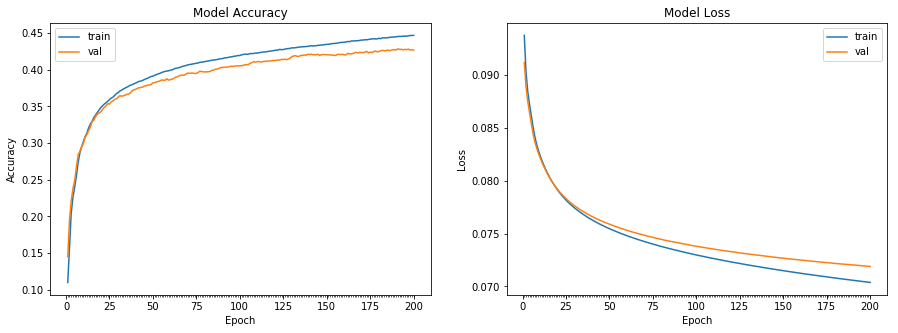

Train on 45833 samples, validate on 4167 samples
Epoch 1/200
45833/45833 [==============================] - 17s - loss: 0.0901 - acc: 0.1589 - val_loss: 0.0886 - val_acc: 0.1790
Epoch 2/200
45833/45833 [==============================] - 17s - loss: 0.0876 - acc: 0.2006 - val_loss: 0.0867 - val_acc: 0.2181
Epoch 3/200
45833/45833 [==============================] - 17s - loss: 0.0860 - acc: 0.2365 - val_loss: 0.0854 - val_acc: 0.2537
Epoch 4/200
45833/45833 [==============================] - 17s - loss: 0.0848 - acc: 0.2632 - val_loss: 0.0843 - val_acc: 0.2741
Epoch 5/200
45833/45833 [==============================] - 17s - loss: 0.0838 - acc: 0.2806 - val_loss: 0.0835 - val_acc: 0.2892
Epoch 6/200
45833/45833 [==============================] - 17s - loss: 0.0830 - acc: 0.2937 - val_loss: 0.0828 - val_acc: 0.2990
Epoch 7/200
45833/45833 [==============================] - 17s - loss: 0.0824 - acc: 0.3039 - val_loss: 0.0822 - val_acc: 0.3089
Epoch 8/200
45833/45833 [=======================

45833/45833 [==============================] - 18s - loss: 0.0717 - acc: 0.4329 - val_loss: 0.0729 - val_acc: 0.4176
Epoch 126/200
45833/45833 [==============================] - 17s - loss: 0.0717 - acc: 0.4336 - val_loss: 0.0729 - val_acc: 0.4178
Epoch 127/200
45833/45833 [==============================] - 17s - loss: 0.0716 - acc: 0.4339 - val_loss: 0.0729 - val_acc: 0.4171
Epoch 128/200
45833/45833 [==============================] - 17s - loss: 0.0716 - acc: 0.4341 - val_loss: 0.0728 - val_acc: 0.4185
Epoch 129/200
45833/45833 [==============================] - 17s - loss: 0.0716 - acc: 0.4339 - val_loss: 0.0728 - val_acc: 0.4180
Epoch 130/200
45833/45833 [==============================] - 17s - loss: 0.0716 - acc: 0.4342 - val_loss: 0.0728 - val_acc: 0.4180
Epoch 131/200
45833/45833 [==============================] - 17s - loss: 0.0715 - acc: 0.4348 - val_loss: 0.0728 - val_acc: 0.4185
Epoch 132/200
45833/45833 [==============================] - 17s - loss: 0.0715 - acc: 0.4356 - v

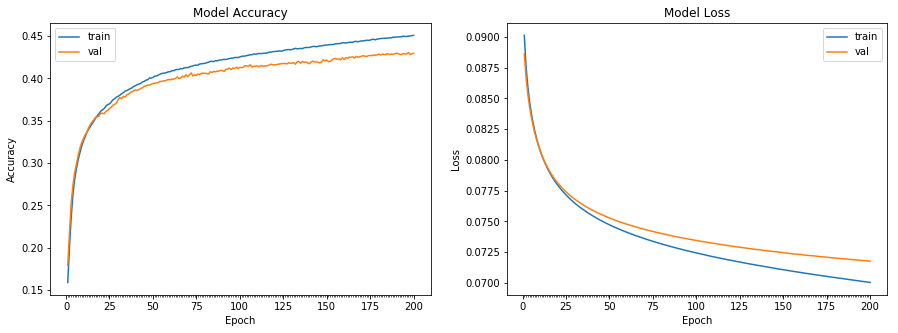

Train on 45833 samples, validate on 4167 samples
Epoch 1/200
45833/45833 [==============================] - 33s - loss: 0.0903 - acc: 0.1485 - val_loss: 0.0883 - val_acc: 0.1886
Epoch 2/200
45833/45833 [==============================] - 33s - loss: 0.0869 - acc: 0.2232 - val_loss: 0.0864 - val_acc: 0.2301
Epoch 3/200
45833/45833 [==============================] - 33s - loss: 0.0853 - acc: 0.2550 - val_loss: 0.0851 - val_acc: 0.2575
Epoch 4/200
45833/45833 [==============================] - 33s - loss: 0.0841 - acc: 0.2746 - val_loss: 0.0841 - val_acc: 0.2700
Epoch 5/200
45833/45833 [==============================] - 33s - loss: 0.0831 - acc: 0.2895 - val_loss: 0.0833 - val_acc: 0.2868
Epoch 6/200
45833/45833 [==============================] - 33s - loss: 0.0824 - acc: 0.3022 - val_loss: 0.0826 - val_acc: 0.2973
Epoch 7/200
45833/45833 [==============================] - 33s - loss: 0.0817 - acc: 0.3125 - val_loss: 0.0820 - val_acc: 0.3048
Epoch 8/200
45833/45833 [=======================

45833/45833 [==============================] - 35s - loss: 0.0715 - acc: 0.4349 - val_loss: 0.0729 - val_acc: 0.4183
Epoch 126/200
45833/45833 [==============================] - 33s - loss: 0.0715 - acc: 0.4348 - val_loss: 0.0729 - val_acc: 0.4178
Epoch 127/200
45833/45833 [==============================] - 33s - loss: 0.0714 - acc: 0.4350 - val_loss: 0.0729 - val_acc: 0.4178
Epoch 128/200
45833/45833 [==============================] - 33s - loss: 0.0714 - acc: 0.4352 - val_loss: 0.0729 - val_acc: 0.4200
Epoch 129/200
45833/45833 [==============================] - 33s - loss: 0.0714 - acc: 0.4353 - val_loss: 0.0729 - val_acc: 0.4207
Epoch 130/200
45833/45833 [==============================] - 33s - loss: 0.0714 - acc: 0.4358 - val_loss: 0.0728 - val_acc: 0.4183
Epoch 131/200
45833/45833 [==============================] - 33s - loss: 0.0713 - acc: 0.4365 - val_loss: 0.0728 - val_acc: 0.4171
Epoch 132/200
45833/45833 [==============================] - 33s - loss: 0.0713 - acc: 0.4362 - v

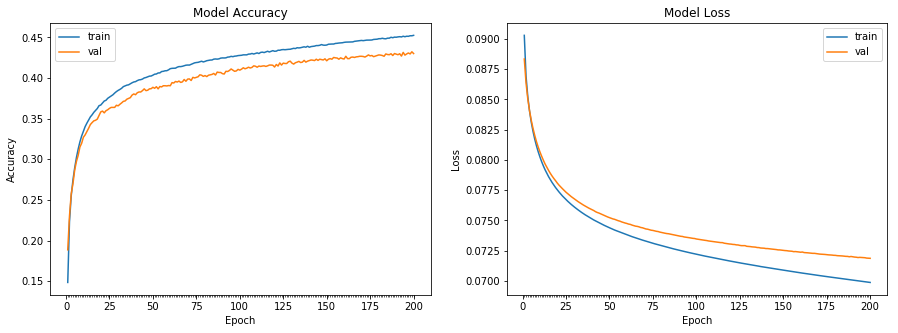

Train on 45833 samples, validate on 4167 samples
Epoch 1/200
45833/45833 [==============================] - 89s - loss: 0.0894 - acc: 0.1710 - val_loss: 0.0873 - val_acc: 0.2177
Epoch 2/200
45833/45833 [==============================] - 88s - loss: 0.0862 - acc: 0.2430 - val_loss: 0.0854 - val_acc: 0.2460
Epoch 3/200
45833/45833 [==============================] - 88s - loss: 0.0845 - acc: 0.2690 - val_loss: 0.0841 - val_acc: 0.2683
Epoch 4/200
45833/45833 [==============================] - 88s - loss: 0.0833 - acc: 0.2885 - val_loss: 0.0831 - val_acc: 0.2853
Epoch 5/200
45833/45833 [==============================] - 89s - loss: 0.0824 - acc: 0.3029 - val_loss: 0.0823 - val_acc: 0.3024
Epoch 6/200
45833/45833 [==============================] - 89s - loss: 0.0816 - acc: 0.3173 - val_loss: 0.0816 - val_acc: 0.3098
Epoch 7/200
45833/45833 [==============================] - 89s - loss: 0.0809 - acc: 0.3253 - val_loss: 0.0809 - val_acc: 0.3185
Epoch 8/200
45833/45833 [=======================

45833/45833 [==============================] - 90s - loss: 0.0712 - acc: 0.4376 - val_loss: 0.0727 - val_acc: 0.4202
Epoch 126/200
45833/45833 [==============================] - 89s - loss: 0.0712 - acc: 0.4385 - val_loss: 0.0728 - val_acc: 0.4197
Epoch 127/200
45833/45833 [==============================] - 89s - loss: 0.0712 - acc: 0.4387 - val_loss: 0.0727 - val_acc: 0.4216
Epoch 128/200
45833/45833 [==============================] - 88s - loss: 0.0711 - acc: 0.4382 - val_loss: 0.0727 - val_acc: 0.4207
Epoch 129/200
45833/45833 [==============================] - 88s - loss: 0.0711 - acc: 0.4384 - val_loss: 0.0727 - val_acc: 0.4183
Epoch 130/200
45833/45833 [==============================] - 89s - loss: 0.0711 - acc: 0.4396 - val_loss: 0.0727 - val_acc: 0.42000.0711 - acc
Epoch 131/200
45833/45833 [==============================] - 89s - loss: 0.0711 - acc: 0.4395 - val_loss: 0.0727 - val_acc: 0.4185
Epoch 132/200
45833/45833 [==============================] - 89s - loss: 0.0710 - acc

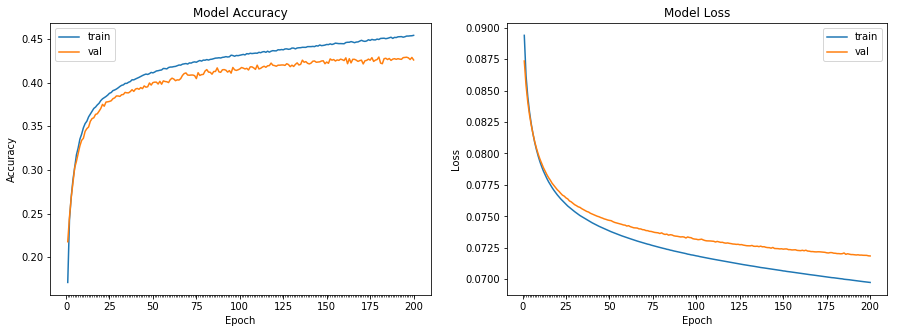

In [21]:
hist_sig=[];time_sigmoid=[]
no_neurons=[32,64,128,256,512,1024,3072]
for i in range(0,len(no_neurons)):
    hidden_neurons = no_neurons[i]
    model = Sequential()
    model.add(Dense(hidden_neurons, input_dim=3072))
    model.add(Activation("sigmoid"))
    model.add(Dense(output_dim=10))
    model.add(Activation("softmax"))
    sgd = optimizers.SGD(lr=0.01)
    model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])
    start = time.time()
    model_info_sigmoid=model.fit(X_train, Y_train, batch_size=100,nb_epoch=200,validation_data=(X_val,Y_val))
    end = time.time()
    hist_sig.extend([model_info_sigmoid.history['acc']])
    hist_sig.extend([model_info_sigmoid.history['loss']])
    hist_sig.extend([model_info_sigmoid.history['val_acc']])
    hist_sig.extend([model_info_sigmoid.history['val_loss']])
    time_sigmoid.extend([(end - start)])
    string = "model_info_sigmoid"+str(hidden_neurons)
    model.save(string)  
    print("Model took %0.2f seconds to train" %(end - start))
    plot_model_history(model_info_sigmoid)

# Training the Model with Tanh as the activation function for different Neurons in one Hidden Layer

C:\Users\Lavanya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=10)`
  
C:\Users\Lavanya\Anaconda3\lib\site-packages\keras\models.py:844: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 45833 samples, validate on 4167 samples
Epoch 1/200
45833/45833 [==============================] - 2s - loss: 0.0921 - acc: 0.1514 - val_loss: 0.0887 - val_acc: 0.2028
Epoch 2/200
45833/45833 [==============================] - 2s - loss: 0.0872 - acc: 0.2206 - val_loss: 0.0855 - val_acc: 0.2453
Epoch 3/200
45833/45833 [==============================] - 2s - loss: 0.0845 - acc: 0.2638 - val_loss: 0.0835 - val_acc: 0.2769
Epoch 4/200
45833/45833 [==============================] - 2s - loss: 0.0827 - acc: 0.2918 - val_loss: 0.0821 - val_acc: 0.2964
Epoch 5/200
45833/45833 [==============================] - 2s - loss: 0.0814 - acc: 0.3119 - val_loss: 0.0811 - val_acc: 0.3151
Epoch 6/200
45833/45833 [==============================] - 2s - loss: 0.0804 - acc: 0.3259 - val_loss: 0.0803 - val_acc: 0.3273
Epoch 7/200
45833/45833 [==============================] - 2s - loss: 0.0796 - acc: 0.3381 - val_loss: 0.0797 - val_acc: 0.3345
Epoch 8/200
45833/45833 [==============================

45833/45833 [==============================] - 2s - loss: 0.0678 - acc: 0.4752 - val_loss: 0.0713 - val_acc: 0.4288
Epoch 128/200
45833/45833 [==============================] - 2s - loss: 0.0677 - acc: 0.4751 - val_loss: 0.0713 - val_acc: 0.4303
Epoch 129/200
45833/45833 [==============================] - 2s - loss: 0.0677 - acc: 0.4754 - val_loss: 0.0713 - val_acc: 0.4284
Epoch 130/200
45833/45833 [==============================] - 2s - loss: 0.0677 - acc: 0.4757 - val_loss: 0.0713 - val_acc: 0.4298
Epoch 131/200
45833/45833 [==============================] - 2s - loss: 0.0676 - acc: 0.4760 - val_loss: 0.0713 - val_acc: 0.4296
Epoch 132/200
45833/45833 [==============================] - 2s - loss: 0.0676 - acc: 0.4767 - val_loss: 0.0713 - val_acc: 0.4303
Epoch 133/200
45833/45833 [==============================] - 2s - loss: 0.0676 - acc: 0.4770 - val_loss: 0.0712 - val_acc: 0.4276
Epoch 134/200
45833/45833 [==============================] - 2s - loss: 0.0675 - acc: 0.4776 - val_loss:

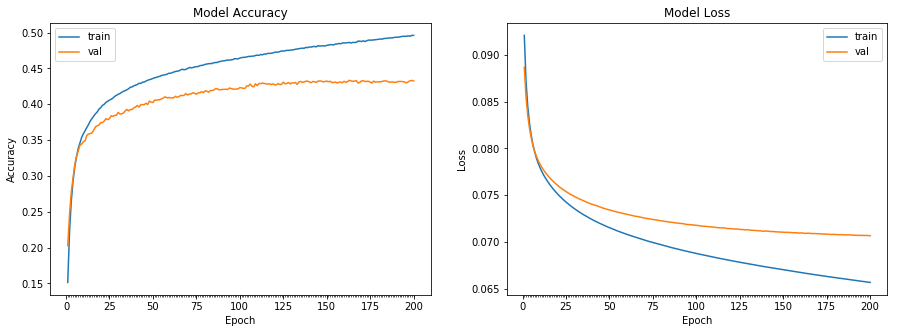

Train on 45833 samples, validate on 4167 samples
Epoch 1/200
45833/45833 [==============================] - 3s - loss: 0.0915 - acc: 0.1651 - val_loss: 0.0882 - val_acc: 0.2059
Epoch 2/200
45833/45833 [==============================] - 3s - loss: 0.0862 - acc: 0.2402 - val_loss: 0.0853 - val_acc: 0.2501
Epoch 3/200
45833/45833 [==============================] - 3s - loss: 0.0838 - acc: 0.2763 - val_loss: 0.0833 - val_acc: 0.2834
Epoch 4/200
45833/45833 [==============================] - 3s - loss: 0.0821 - acc: 0.3009 - val_loss: 0.0819 - val_acc: 0.3036
Epoch 5/200
45833/45833 [==============================] - 3s - loss: 0.0808 - acc: 0.3180 - val_loss: 0.0808 - val_acc: 0.3153
Epoch 6/200
45833/45833 [==============================] - 3s - loss: 0.0799 - acc: 0.3310 - val_loss: 0.0800 - val_acc: 0.3245
Epoch 7/200
45833/45833 [==============================] - 3s - loss: 0.0791 - acc: 0.3397 - val_loss: 0.0793 - val_acc: 0.3350
Epoch 8/200
45833/45833 [==============================

45833/45833 [==============================] - 3s - loss: 0.0661 - acc: 0.4912 - val_loss: 0.0710 - val_acc: 0.4298
Epoch 127/200
45833/45833 [==============================] - 3s - loss: 0.0661 - acc: 0.4910 - val_loss: 0.0710 - val_acc: 0.4298
Epoch 128/200
45833/45833 [==============================] - 3s - loss: 0.0660 - acc: 0.4913 - val_loss: 0.0710 - val_acc: 0.4300
Epoch 129/200
45833/45833 [==============================] - 3s - loss: 0.0660 - acc: 0.4920 - val_loss: 0.0710 - val_acc: 0.4305
Epoch 130/200
45833/45833 [==============================] - 3s - loss: 0.0660 - acc: 0.4925 - val_loss: 0.0710 - val_acc: 0.4291
Epoch 131/200
45833/45833 [==============================] - 3s - loss: 0.0659 - acc: 0.4922 - val_loss: 0.0710 - val_acc: 0.4312
Epoch 132/200
45833/45833 [==============================] - 3s - loss: 0.0659 - acc: 0.4935 - val_loss: 0.0709 - val_acc: 0.4303
Epoch 133/200
45833/45833 [==============================] - 3s - loss: 0.0658 - acc: 0.4944 - val_loss:

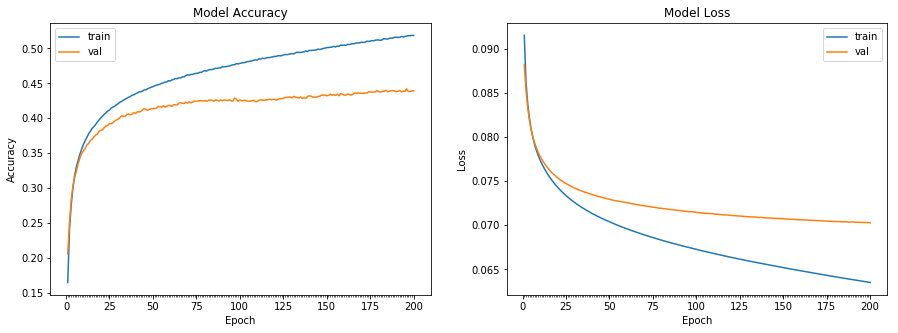

Train on 45833 samples, validate on 4167 samples
Epoch 1/200
45833/45833 [==============================] - 5s - loss: 0.0919 - acc: 0.1626 - val_loss: 0.0880 - val_acc: 0.2174
Epoch 2/200
45833/45833 [==============================] - 5s - loss: 0.0859 - acc: 0.2454 - val_loss: 0.0847 - val_acc: 0.2580
Epoch 3/200
45833/45833 [==============================] - 5s - loss: 0.0834 - acc: 0.2819 - val_loss: 0.0827 - val_acc: 0.2865
Epoch 4/200
45833/45833 [==============================] - 5s - loss: 0.0817 - acc: 0.3069 - val_loss: 0.0813 - val_acc: 0.3050
Epoch 5/200
45833/45833 [==============================] - 5s - loss: 0.0804 - acc: 0.3249 - val_loss: 0.0803 - val_acc: 0.3216
Epoch 6/200
45833/45833 [==============================] - 5s - loss: 0.0795 - acc: 0.3370 - val_loss: 0.0795 - val_acc: 0.3360
Epoch 7/200
45833/45833 [==============================] - 5s - loss: 0.0787 - acc: 0.3459 - val_loss: 0.0789 - val_acc: 0.3449
Epoch 8/200
45833/45833 [==============================

45833/45833 [==============================] - 5s - loss: 0.0645 - acc: 0.5073 - val_loss: 0.0702 - val_acc: 0.4406
Epoch 128/200
45833/45833 [==============================] - 5s - loss: 0.0644 - acc: 0.5088 - val_loss: 0.0702 - val_acc: 0.4396
Epoch 129/200
45833/45833 [==============================] - 5s - loss: 0.0644 - acc: 0.5090 - val_loss: 0.0702 - val_acc: 0.4401
Epoch 130/200
45833/45833 [==============================] - 5s - loss: 0.0643 - acc: 0.5097 - val_loss: 0.0702 - val_acc: 0.4394
Epoch 131/200
45833/45833 [==============================] - 5s - loss: 0.0643 - acc: 0.5100 - val_loss: 0.0702 - val_acc: 0.4411
Epoch 132/200
45833/45833 [==============================] - 5s - loss: 0.0642 - acc: 0.5098 - val_loss: 0.0701 - val_acc: 0.4425
Epoch 133/200
45833/45833 [==============================] - 5s - loss: 0.0642 - acc: 0.5102 - val_loss: 0.0702 - val_acc: 0.4408
Epoch 134/200
45833/45833 [==============================] - 5s - loss: 0.0641 - acc: 0.5107 - val_loss:

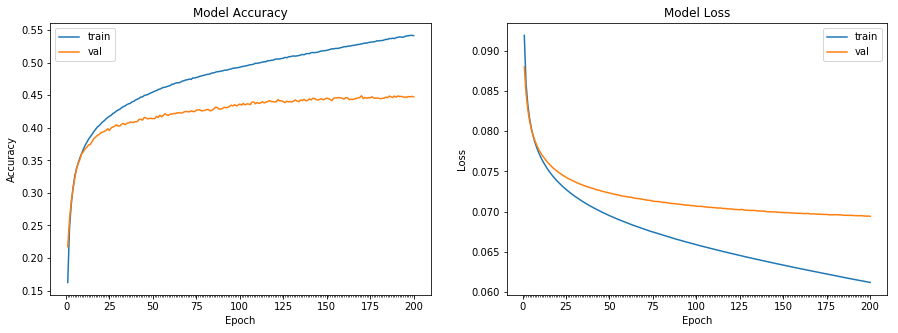

Train on 45833 samples, validate on 4167 samples
Epoch 1/200
45833/45833 [==============================] - 9s - loss: 0.0898 - acc: 0.1961 - val_loss: 0.0861 - val_acc: 0.2503
Epoch 2/200
45833/45833 [==============================] - 9s - loss: 0.0842 - acc: 0.2724 - val_loss: 0.0833 - val_acc: 0.2913
Epoch 3/200
45833/45833 [==============================] - 9s - loss: 0.0819 - acc: 0.3045 - val_loss: 0.0816 - val_acc: 0.3105
Epoch 4/200
45833/45833 [==============================] - 9s - loss: 0.0803 - acc: 0.3247 - val_loss: 0.0804 - val_acc: 0.3261
Epoch 5/200
45833/45833 [==============================] - 9s - loss: 0.0792 - acc: 0.3386 - val_loss: 0.0794 - val_acc: 0.3348
Epoch 6/200
45833/45833 [==============================] - 9s - loss: 0.0783 - acc: 0.3502 - val_loss: 0.0787 - val_acc: 0.3449
Epoch 7/200
45833/45833 [==============================] - 9s - loss: 0.0775 - acc: 0.3602 - val_loss: 0.0782 - val_acc: 0.3537
Epoch 8/200
45833/45833 [==============================

45833/45833 [==============================] - 13s - loss: 0.0629 - acc: 0.5256 - val_loss: 0.0701 - val_acc: 0.4320
Epoch 126/200
45833/45833 [==============================] - 13s - loss: 0.0628 - acc: 0.5270 - val_loss: 0.0701 - val_acc: 0.4315
Epoch 127/200
45833/45833 [==============================] - 13s - loss: 0.0628 - acc: 0.5278 - val_loss: 0.0701 - val_acc: 0.4308
Epoch 128/200
45833/45833 [==============================] - 13s - loss: 0.0627 - acc: 0.5282 - val_loss: 0.0701 - val_acc: 0.4320
Epoch 129/200
45833/45833 [==============================] - 13s - loss: 0.0626 - acc: 0.5285 - val_loss: 0.0701 - val_acc: 0.4317
Epoch 130/200
45833/45833 [==============================] - 13s - loss: 0.0626 - acc: 0.5289 - val_loss: 0.0700 - val_acc: 0.4322
Epoch 131/200
45833/45833 [==============================] - 13s - loss: 0.0625 - acc: 0.5297 - val_loss: 0.0700 - val_acc: 0.4327
Epoch 132/200
45833/45833 [==============================] - 13s - loss: 0.0625 - acc: 0.5302 - v

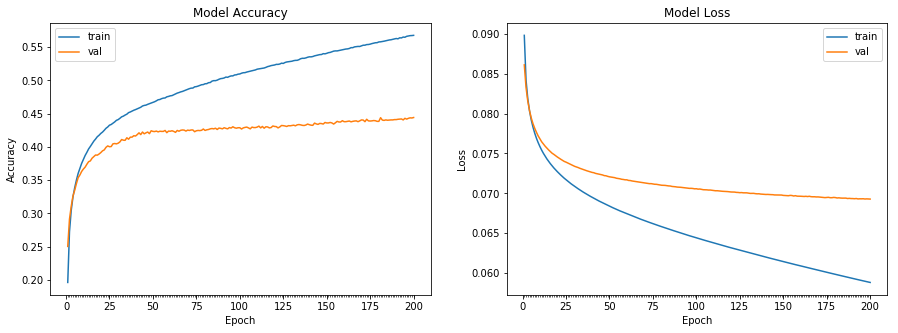

Train on 45833 samples, validate on 4167 samples
Epoch 1/200
45833/45833 [==============================] - 23s - loss: 0.0903 - acc: 0.1878 - val_loss: 0.0866 - val_acc: 0.2349
Epoch 2/200
45833/45833 [==============================] - 23s - loss: 0.0845 - acc: 0.2651 - val_loss: 0.0834 - val_acc: 0.2779
Epoch 3/200
45833/45833 [==============================] - 23s - loss: 0.0819 - acc: 0.3035 - val_loss: 0.0813 - val_acc: 0.3053
Epoch 4/200
45833/45833 [==============================] - 23s - loss: 0.0801 - acc: 0.3265 - val_loss: 0.0800 - val_acc: 0.3216
Epoch 5/200
45833/45833 [==============================] - 23s - loss: 0.0788 - acc: 0.3451 - val_loss: 0.0790 - val_acc: 0.3350
Epoch 6/200
45833/45833 [==============================] - 23s - loss: 0.0778 - acc: 0.3579 - val_loss: 0.0783 - val_acc: 0.3480
Epoch 7/200
45833/45833 [==============================] - 23s - loss: 0.0770 - acc: 0.3672 - val_loss: 0.0776 - val_acc: 0.3540
Epoch 8/200
45833/45833 [=======================

45833/45833 [==============================] - 23s - loss: 0.0613 - acc: 0.5433 - val_loss: 0.0693 - val_acc: 0.4461
Epoch 126/200
45833/45833 [==============================] - 19s - loss: 0.0613 - acc: 0.5438 - val_loss: 0.0693 - val_acc: 0.4488
Epoch 127/200
45833/45833 [==============================] - 17s - loss: 0.0612 - acc: 0.5444 - val_loss: 0.0692 - val_acc: 0.4468
Epoch 128/200
45833/45833 [==============================] - 17s - loss: 0.0611 - acc: 0.5460 - val_loss: 0.0692 - val_acc: 0.4471
Epoch 129/200
45833/45833 [==============================] - 17s - loss: 0.0611 - acc: 0.5457 - val_loss: 0.0692 - val_acc: 0.4485
Epoch 130/200
45833/45833 [==============================] - 17s - loss: 0.0610 - acc: 0.5467 - val_loss: 0.0692 - val_acc: 0.4480
Epoch 131/200
45833/45833 [==============================] - 17s - loss: 0.0609 - acc: 0.5462 - val_loss: 0.0692 - val_acc: 0.4478
Epoch 132/200
45833/45833 [==============================] - 17s - loss: 0.0609 - acc: 0.5487 - v

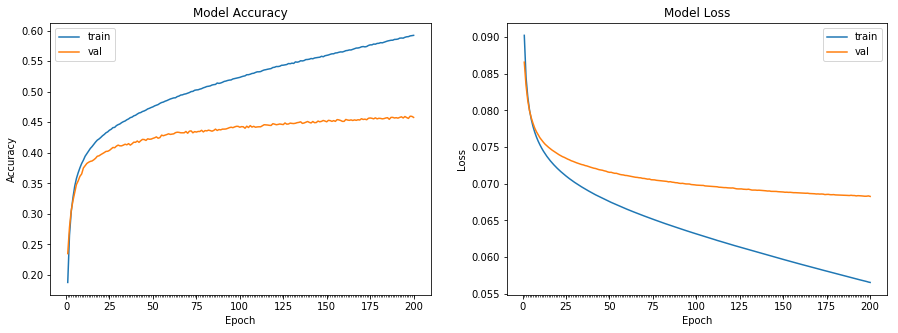

Train on 45833 samples, validate on 4167 samples
Epoch 1/200
45833/45833 [==============================] - 33s - loss: 0.0881 - acc: 0.2227 - val_loss: 0.0846 - val_acc: 0.2671
Epoch 2/200
45833/45833 [==============================] - 32s - loss: 0.0831 - acc: 0.2882 - val_loss: 0.0816 - val_acc: 0.2995
Epoch 3/200
45833/45833 [==============================] - 33s - loss: 0.0807 - acc: 0.3193 - val_loss: 0.0798 - val_acc: 0.3276
Epoch 4/200
45833/45833 [==============================] - 33s - loss: 0.0791 - acc: 0.3403 - val_loss: 0.0786 - val_acc: 0.3427
Epoch 5/200
45833/45833 [==============================] - 33s - loss: 0.0779 - acc: 0.3561 - val_loss: 0.0777 - val_acc: 0.3523
Epoch 6/200
45833/45833 [==============================] - 33s - loss: 0.0770 - acc: 0.3672 - val_loss: 0.0770 - val_acc: 0.3614
Epoch 7/200
45833/45833 [==============================] - 33s - loss: 0.0762 - acc: 0.3771 - val_loss: 0.0764 - val_acc: 0.3614
Epoch 8/200
45833/45833 [=======================

45833/45833 [==============================] - 48s - loss: 0.0599 - acc: 0.5600 - val_loss: 0.0684 - val_acc: 0.4557
Epoch 126/200
45833/45833 [==============================] - 44s - loss: 0.0598 - acc: 0.5607 - val_loss: 0.0684 - val_acc: 0.4572
Epoch 127/200
45833/45833 [==============================] - 44s - loss: 0.0598 - acc: 0.5619 - val_loss: 0.0684 - val_acc: 0.4552
Epoch 128/200
45833/45833 [==============================] - 44s - loss: 0.0597 - acc: 0.5626 - val_loss: 0.0684 - val_acc: 0.4586
Epoch 129/200
45833/45833 [==============================] - 44s - loss: 0.0596 - acc: 0.5634 - val_loss: 0.0684 - val_acc: 0.4564
Epoch 130/200
45833/45833 [==============================] - 44s - loss: 0.0595 - acc: 0.5636 - val_loss: 0.0684 - val_acc: 0.4579
Epoch 131/200
45833/45833 [==============================] - 44s - loss: 0.0594 - acc: 0.5643 - val_loss: 0.0683 - val_acc: 0.4560
Epoch 132/200
45833/45833 [==============================] - 44s - loss: 0.0594 - acc: 0.5652 - v

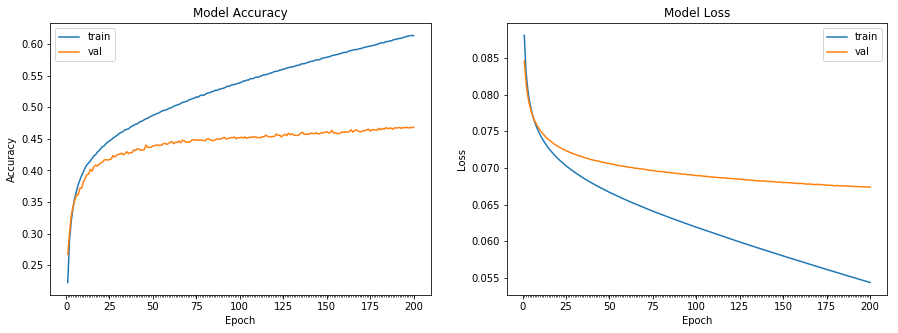

Train on 45833 samples, validate on 4167 samples
Epoch 1/200
45833/45833 [==============================] - 88s - loss: 0.0868 - acc: 0.2297 - val_loss: 0.0831 - val_acc: 0.2861
Epoch 2/200
45833/45833 [==============================] - 88s - loss: 0.0811 - acc: 0.3124 - val_loss: 0.0800 - val_acc: 0.3300
Epoch 3/200
45833/45833 [==============================] - 88s - loss: 0.0787 - acc: 0.3448 - val_loss: 0.0783 - val_acc: 0.3485
Epoch 4/200
45833/45833 [==============================] - 88s - loss: 0.0772 - acc: 0.3639 - val_loss: 0.0771 - val_acc: 0.3624
Epoch 5/200
45833/45833 [==============================] - 88s - loss: 0.0761 - acc: 0.3758 - val_loss: 0.0763 - val_acc: 0.3729
Epoch 6/200
45833/45833 [==============================] - 88s - loss: 0.0753 - acc: 0.3869 - val_loss: 0.0758 - val_acc: 0.3777
Epoch 7/200
45833/45833 [==============================] - 88s - loss: 0.0746 - acc: 0.3947 - val_loss: 0.0753 - val_acc: 0.3861
Epoch 8/200
45833/45833 [=======================

45833/45833 [==============================] - 88s - loss: 0.0580 - acc: 0.5788 - val_loss: 0.0679 - val_acc: 0.4600
Epoch 126/200
45833/45833 [==============================] - 88s - loss: 0.0579 - acc: 0.5804 - val_loss: 0.0679 - val_acc: 0.4596
Epoch 127/200
45833/45833 [==============================] - 88s - loss: 0.0579 - acc: 0.5805 - val_loss: 0.0678 - val_acc: 0.4603
Epoch 128/200
45833/45833 [==============================] - 88s - loss: 0.0578 - acc: 0.5815 - val_loss: 0.0678 - val_acc: 0.4605
Epoch 129/200
45833/45833 [==============================] - 88s - loss: 0.0577 - acc: 0.5818 - val_loss: 0.0678 - val_acc: 0.4596
Epoch 130/200
45833/45833 [==============================] - 88s - loss: 0.0576 - acc: 0.5832 - val_loss: 0.0678 - val_acc: 0.4593
Epoch 131/200
45833/45833 [==============================] - 89s - loss: 0.0575 - acc: 0.5837 - val_loss: 0.0677 - val_acc: 0.4622
Epoch 132/200
45833/45833 [==============================] - 88s - loss: 0.0574 - acc: 0.5849 - v

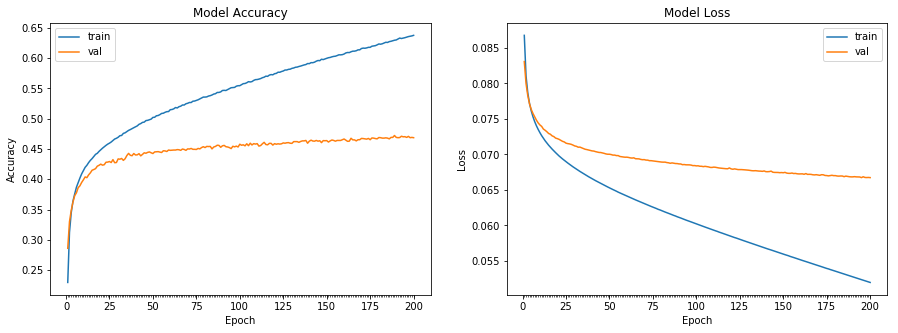

In [22]:
hist_tanh=[];time_tanh=[];
no_neurons=[32,64,128,256,512,1024,3072]
for i in range(0,len(no_neurons)):
    hidden_neurons = no_neurons[i]
    model = Sequential()
    model.add(Dense(hidden_neurons, input_dim=3072))
    model.add(Activation("tanh"))
    model.add(Dense(output_dim=10))
    model.add(Activation("softmax"))
    sgd = optimizers.SGD(lr=0.01)
    model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])
    start = time.time()
    model_info_tanh=model.fit(X_train, Y_train, batch_size=100,nb_epoch=200,validation_data=(X_val,Y_val))
    end = time.time()
    hist_tanh.extend([model_info_tanh.history['acc']])
    hist_tanh.extend([model_info_tanh.history['loss']])
    hist_tanh.extend([model_info_tanh.history['val_acc']])
    hist_tanh.extend([model_info_tanh.history['val_loss']])
    time_tanh.extend([(end - start)])
    string = "model_info_tanh"+str(hidden_neurons)
    model.save(string)  
    print("Model took %0.2f seconds to train" %(end - start))
    plot_model_history(model_info_tanh)

# Training the Model with ReLU as the activation function for different Neurons in three Hidden Layers

C:\Users\Lavanya\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=10)`
  if __name__ == '__main__':
C:\Users\Lavanya\Anaconda3\lib\site-packages\keras\models.py:844: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 45833 samples, validate on 4167 samples
Epoch 1/150
45833/45833 [==============================] - 3s - loss: 0.0927 - acc: 0.1060 - val_loss: 0.0917 - val_acc: 0.1243
Epoch 2/150
45833/45833 [==============================] - 2s - loss: 0.0909 - acc: 0.1324 - val_loss: 0.0905 - val_acc: 0.1401
Epoch 3/150
45833/45833 [==============================] - 2s - loss: 0.0898 - acc: 0.1519 - val_loss: 0.0896 - val_acc: 0.1579
Epoch 4/150
45833/45833 [==============================] - 2s - loss: 0.0890 - acc: 0.1682 - val_loss: 0.0889 - val_acc: 0.1687
Epoch 5/150
45833/45833 [==============================] - 3s - loss: 0.0883 - acc: 0.1829 - val_loss: 0.0883 - val_acc: 0.1877
Epoch 6/150
45833/45833 [==============================] - 2s - loss: 0.0877 - acc: 0.1999 - val_loss: 0.0878 - val_acc: 0.1992
Epoch 7/150
45833/45833 [==============================] - 3s - loss: 0.0872 - acc: 0.2137 - val_loss: 0.0873 - val_acc: 0.2119
Epoch 8/150
45833/45833 [==============================

45833/45833 [==============================] - 4s - loss: 0.0671 - acc: 0.4740 - val_loss: 0.0708 - val_acc: 0.4308
Epoch 128/150
45833/45833 [==============================] - 3s - loss: 0.0670 - acc: 0.4735 - val_loss: 0.0707 - val_acc: 0.4315
Epoch 129/150
45833/45833 [==============================] - 3s - loss: 0.0670 - acc: 0.4750 - val_loss: 0.0707 - val_acc: 0.4308
Epoch 130/150
45833/45833 [==============================] - 3s - loss: 0.0669 - acc: 0.4763 - val_loss: 0.0707 - val_acc: 0.4317
Epoch 131/150
45833/45833 [==============================] - 3s - loss: 0.0669 - acc: 0.4763 - val_loss: 0.0707 - val_acc: 0.4298
Epoch 132/150
45833/45833 [==============================] - 3s - loss: 0.0668 - acc: 0.4769 - val_loss: 0.0707 - val_acc: 0.4334
Epoch 133/150
45833/45833 [==============================] - 3s - loss: 0.0667 - acc: 0.4775 - val_loss: 0.0706 - val_acc: 0.4308
Epoch 134/150
45833/45833 [==============================] - 4s - loss: 0.0667 - acc: 0.4780 - val_loss:

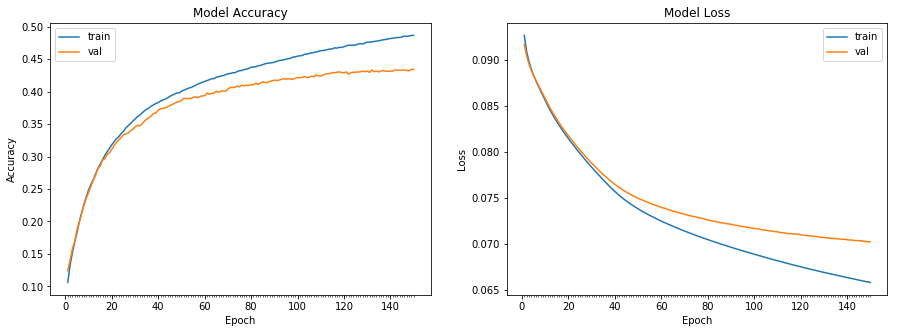

Train on 45833 samples, validate on 4167 samples
Epoch 1/150
45833/45833 [==============================] - 9s - loss: 0.0912 - acc: 0.1317 - val_loss: 0.0900 - val_acc: 0.1560
Epoch 2/150
45833/45833 [==============================] - 9s - loss: 0.0887 - acc: 0.1874 - val_loss: 0.0881 - val_acc: 0.2090
Epoch 3/150
45833/45833 [==============================] - 9s - loss: 0.0869 - acc: 0.2216 - val_loss: 0.0867 - val_acc: 0.2232
Epoch 4/150
45833/45833 [==============================] - 9s - loss: 0.0856 - acc: 0.2434 - val_loss: 0.0856 - val_acc: 0.2453
Epoch 5/150
45833/45833 [==============================] - 9s - loss: 0.0845 - acc: 0.2621 - val_loss: 0.0846 - val_acc: 0.2604
Epoch 6/150
45833/45833 [==============================] - 9s - loss: 0.0836 - acc: 0.2768 - val_loss: 0.0837 - val_acc: 0.2741
Epoch 7/150
45833/45833 [==============================] - 9s - loss: 0.0827 - acc: 0.2895 - val_loss: 0.0830 - val_acc: 0.2906
Epoch 8/150
45833/45833 [==============================

45833/45833 [==============================] - 9s - loss: 0.0593 - acc: 0.5517 - val_loss: 0.0668 - val_acc: 0.4754
Epoch 128/150
45833/45833 [==============================] - 9s - loss: 0.0592 - acc: 0.5527 - val_loss: 0.0668 - val_acc: 0.4713
Epoch 129/150
45833/45833 [==============================] - 8s - loss: 0.0591 - acc: 0.5536 - val_loss: 0.0668 - val_acc: 0.4728
Epoch 130/150
45833/45833 [==============================] - 9s - loss: 0.0590 - acc: 0.5541 - val_loss: 0.0667 - val_acc: 0.4732
Epoch 131/150
45833/45833 [==============================] - 9s - loss: 0.0589 - acc: 0.5546 - val_loss: 0.0667 - val_acc: 0.4740
Epoch 132/150
45833/45833 [==============================] - 10s - loss: 0.0588 - acc: 0.5560 - val_loss: 0.0667 - val_acc: 0.4735
Epoch 133/150
45833/45833 [==============================] - 10s - loss: 0.0588 - acc: 0.5573 - val_loss: 0.0666 - val_acc: 0.4730
Epoch 134/150
45833/45833 [==============================] - 10s - loss: 0.0587 - acc: 0.5583 - val_lo

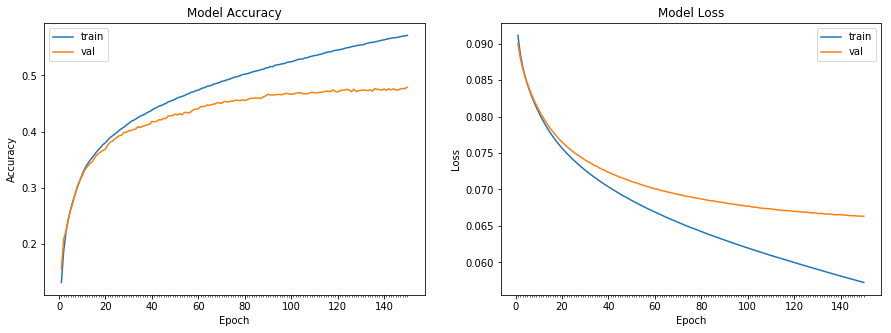

Train on 45833 samples, validate on 4167 samples
Epoch 1/150
45833/45833 [==============================] - 39s - loss: 0.0898 - acc: 0.1551 - val_loss: 0.0878 - val_acc: 0.1939
Epoch 2/150
45833/45833 [==============================] - 37s - loss: 0.0862 - acc: 0.2257 - val_loss: 0.0854 - val_acc: 0.2465
Epoch 3/150
45833/45833 [==============================] - 37s - loss: 0.0842 - acc: 0.2611 - val_loss: 0.0837 - val_acc: 0.2757
Epoch 4/150
45833/45833 [==============================] - 37s - loss: 0.0827 - acc: 0.2878 - val_loss: 0.0824 - val_acc: 0.2997
Epoch 5/150
45833/45833 [==============================] - 40s - loss: 0.0814 - acc: 0.3075 - val_loss: 0.0813 - val_acc: 0.3137
Epoch 6/150
45833/45833 [==============================] - 42s - loss: 0.0803 - acc: 0.3237 - val_loss: 0.0804 - val_acc: 0.3249
Epoch 7/150
45833/45833 [==============================] - 38s - loss: 0.0793 - acc: 0.3369 - val_loss: 0.0795 - val_acc: 0.3386
Epoch 8/150
45833/45833 [=======================

45833/45833 [==============================] - 37s - loss: 0.0518 - acc: 0.6294 - val_loss: 0.0642 - val_acc: 0.4968
Epoch 126/150
45833/45833 [==============================] - 38s - loss: 0.0517 - acc: 0.6309 - val_loss: 0.0642 - val_acc: 0.4970
Epoch 127/150
45833/45833 [==============================] - 37s - loss: 0.0515 - acc: 0.6315 - val_loss: 0.0642 - val_acc: 0.4999
Epoch 128/150
45833/45833 [==============================] - 39s - loss: 0.0514 - acc: 0.6331 - val_loss: 0.0642 - val_acc: 0.4956
Epoch 129/150
45833/45833 [==============================] - 42s - loss: 0.0512 - acc: 0.6340 - val_loss: 0.0642 - val_acc: 0.4987
Epoch 130/150
45833/45833 [==============================] - 41s - loss: 0.0511 - acc: 0.6359 - val_loss: 0.0642 - val_acc: 0.4992
Epoch 131/150
45833/45833 [==============================] - 38s - loss: 0.0509 - acc: 0.6370 - val_loss: 0.0641 - val_acc: 0.5004
Epoch 132/150
45833/45833 [==============================] - 36s - loss: 0.0508 - acc: 0.6394 - v

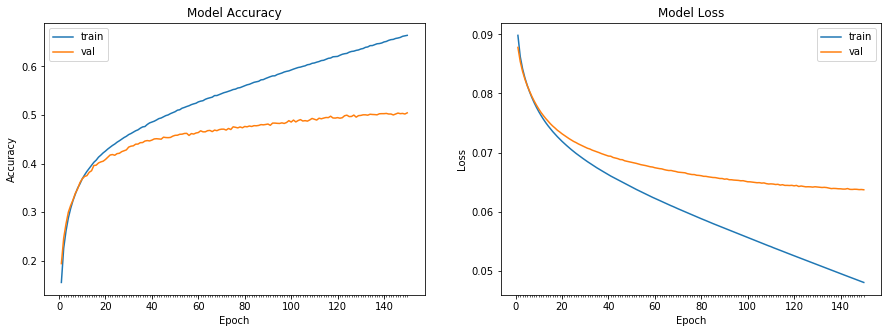

Train on 45833 samples, validate on 4167 samples
Epoch 1/150
45833/45833 [==============================] - 439s - loss: 0.0871 - acc: 0.2089 - val_loss: 0.0844 - val_acc: 0.2652
Epoch 2/150
45833/45833 [==============================] - 424s - loss: 0.0826 - acc: 0.2942 - val_loss: 0.0814 - val_acc: 0.3165
Epoch 3/150
45833/45833 [==============================] - 359s - loss: 0.0801 - acc: 0.3320 - val_loss: 0.0794 - val_acc: 0.3461
Epoch 4/150
45833/45833 [==============================] - 316s - loss: 0.0783 - acc: 0.3559 - val_loss: 0.0779 - val_acc: 0.3597
Epoch 5/150
45833/45833 [==============================] - 307s - loss: 0.0769 - acc: 0.3730 - val_loss: 0.0767 - val_acc: 0.3744
Epoch 6/150
45833/45833 [==============================] - 335s - loss: 0.0756 - acc: 0.3896 - val_loss: 0.0758 - val_acc: 0.3818
Epoch 7/150
45833/45833 [==============================] - 398s - loss: 0.0746 - acc: 0.3997 - val_loss: 0.0749 - val_acc: 0.3892
Epoch 8/150
45833/45833 [================

45833/45833 [==============================] - 327s - loss: 0.0378 - acc: 0.7609 - val_loss: 0.0614 - val_acc: 0.5313
Epoch 126/150
45833/45833 [==============================] - 297s - loss: 0.0376 - acc: 0.7619 - val_loss: 0.0613 - val_acc: 0.5253
Epoch 127/150
45833/45833 [==============================] - 298s - loss: 0.0373 - acc: 0.7636 - val_loss: 0.0613 - val_acc: 0.5287
Epoch 128/150
45833/45833 [==============================] - 295s - loss: 0.0371 - acc: 0.7662 - val_loss: 0.0613 - val_acc: 0.5289
Epoch 129/150
45833/45833 [==============================] - 296s - loss: 0.0368 - acc: 0.7679 - val_loss: 0.0613 - val_acc: 0.5289
Epoch 130/150
45833/45833 [==============================] - 297s - loss: 0.0366 - acc: 0.7701 - val_loss: 0.0614 - val_acc: 0.5280
Epoch 131/150
45833/45833 [==============================] - 295s - loss: 0.0363 - acc: 0.7721 - val_loss: 0.0613 - val_acc: 0.5294
Epoch 132/150
45833/45833 [==============================] - 295s - loss: 0.0361 - acc: 0.

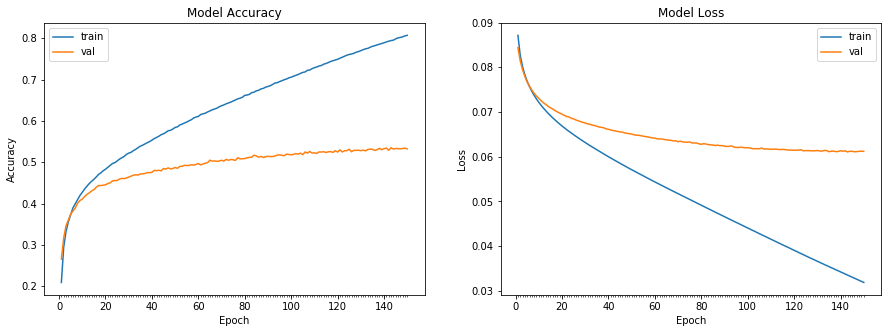

In [25]:
hist_layer3=[];time_layer3=[]
no_neurons=[32,128,512,3072]
for i in range(0,len(no_neurons)):
    hidden_neurons = no_neurons[i]
    model = Sequential()
    for j in range(0,3):
        model.add(Dense(hidden_neurons, input_dim=3072))
        model.add(Activation("relu"))
    model.add(Dense(output_dim=10))
    model.add(Activation("softmax"))
    sgd = optimizers.SGD(lr=0.01)
    model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])
    start = time.time()
    model_info_layer3=model.fit(X_train, Y_train, batch_size=100,nb_epoch=150,validation_data=(X_val,Y_val))
    end = time.time()
    hist_layer3.extend([model_info_layer3.history['acc']])
    hist_layer3.extend([model_info_layer3.history['loss']])
    hist_layer3.extend([model_info_layer3.history['val_acc']])
    hist_layer3.extend([model_info_layer3.history['val_loss']])
    time_layer3.extend([(end - start)])
    string = "model_info_layer3_"+str(hidden_neurons)
    model.save(string)  
    print("Model took %0.2f seconds to train" %(end - start))
    plot_model_history(model_info_layer3)

# Training the Model with ReLU as the activation function for 3072 Neurons in three Hidden Layers for different Batch sizes

C:\Users\Lavanya\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=10)`
  if __name__ == '__main__':
C:\Users\Lavanya\Anaconda3\lib\site-packages\keras\models.py:844: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 45833 samples, validate on 4167 samples
Epoch 1/100
45833/45833 [==============================] - 460s - loss: 0.0840 - acc: 0.2733 - val_loss: 0.0803 - val_acc: 0.3293
Epoch 2/100
45833/45833 [==============================] - 459s - loss: 0.0778 - acc: 0.3629 - val_loss: 0.0767 - val_acc: 0.3765
Epoch 3/100
45833/45833 [==============================] - 459s - loss: 0.0748 - acc: 0.3975 - val_loss: 0.0746 - val_acc: 0.3988
Epoch 4/100
45833/45833 [==============================] - 459s - loss: 0.0727 - acc: 0.4200 - val_loss: 0.0732 - val_acc: 0.4154
Epoch 5/100
45833/45833 [==============================] - 460s - loss: 0.0710 - acc: 0.4388 - val_loss: 0.0721 - val_acc: 0.4226
Epoch 6/100
45833/45833 [==============================] - 463s - loss: 0.0697 - acc: 0.4529 - val_loss: 0.0712 - val_acc: 0.4274
Epoch 7/100
45833/45833 [==============================] - 465s - loss: 0.0685 - acc: 0.4646 - val_loss: 0.0705 - val_acc: 0.4389
Epoch 8/100
45833/45833 [================

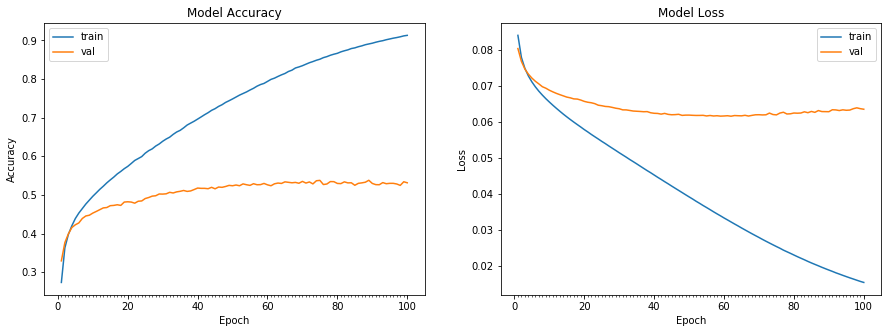

Train on 45833 samples, validate on 4167 samples
Epoch 1/100
45833/45833 [==============================] - 237s - loss: 0.0890 - acc: 0.1643 - val_loss: 0.0869 - val_acc: 0.2227
Epoch 2/100
45833/45833 [==============================] - 237s - loss: 0.0855 - acc: 0.2506 - val_loss: 0.0845 - val_acc: 0.2676
Epoch 3/100
45833/45833 [==============================] - 237s - loss: 0.0834 - acc: 0.2852 - val_loss: 0.0829 - val_acc: 0.2981
Epoch 4/100
45833/45833 [==============================] - 237s - loss: 0.0819 - acc: 0.3085 - val_loss: 0.0815 - val_acc: 0.3134
Epoch 5/100
45833/45833 [==============================] - 237s - loss: 0.0806 - acc: 0.3265 - val_loss: 0.0804 - val_acc: 0.3278
Epoch 6/100
45833/45833 [==============================] - 238s - loss: 0.0795 - acc: 0.3405 - val_loss: 0.0795 - val_acc: 0.3389
Epoch 7/100
45833/45833 [==============================] - 238s - loss: 0.0786 - acc: 0.3521 - val_loss: 0.0786 - val_acc: 0.3525
Epoch 8/100
45833/45833 [================

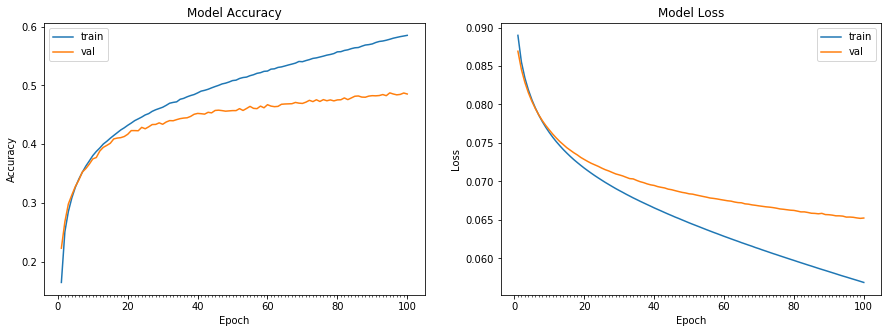

In [28]:
batch_size_hist=[];time_batch_size=[];
batch_size_list = [40,200]
for i in range(0,len(batch_size_list)):
    batch = batch_size_list[i]
    model = Sequential()
    for j in range(0,3):
        model.add(Dense(3072, input_dim=3072))
        model.add(Activation("relu"))
    model.add(Dense(output_dim=10))
    model.add(Activation("softmax"))
    sgd = optimizers.SGD(lr=0.01)
    model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])
    start = time.time()
    model_info_batchsize=model.fit(X_train, Y_train, batch_size=batch,nb_epoch=100,validation_data=(X_val,Y_val))
    end = time.time()
    batch_size_hist.extend([model_info_batchsize.history['acc']])
    batch_size_hist.extend([model_info_batchsize.history['loss']])
    batch_size_hist.extend([model_info_batchsize.history['val_acc']])
    batch_size_hist.extend([model_info_batchsize.history['val_loss']])
    time_batch_size.extend([(end - start)])
    string = "model_info_batch_size_"+str(batch)
    model.save(string) 
    print("Model took %0.2f seconds to train" %(end - start))
    plot_model_history(model_info_batchsize)

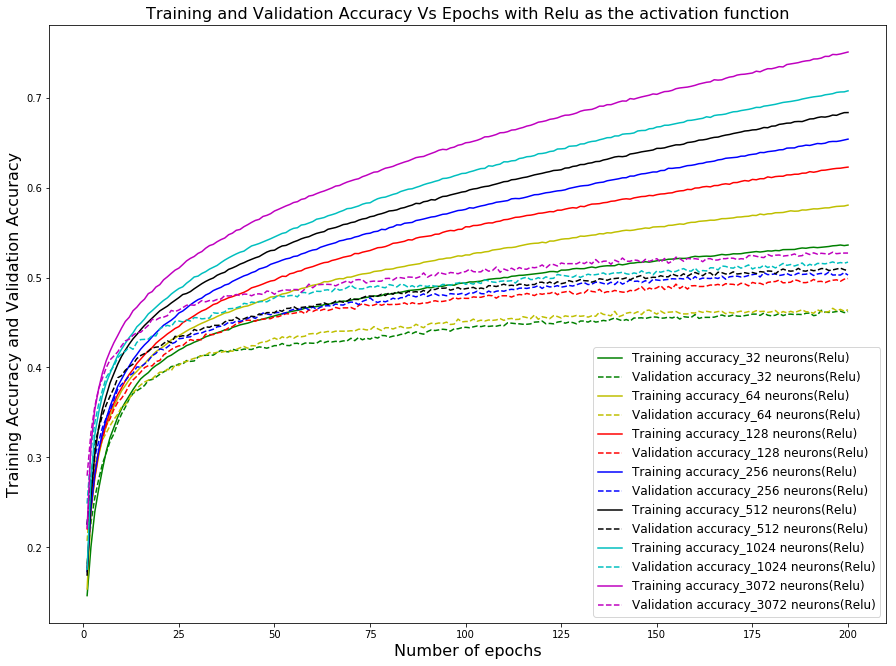

In [110]:
plt.figure(figsize = (15,11))
epoch=range(1,201)
plt.plot(epoch, hist[0], 'g-', label = "Training accuracy_32 neurons(Relu)")
plt.plot(epoch, hist[2], 'g--', label = "Validation accuracy_32 neurons(Relu)")
plt.plot(epoch, hist[4], 'y-', label = "Training accuracy_64 neurons(Relu)")
plt.plot(epoch, hist[6], 'y--', label = "Validation accuracy_64 neurons(Relu)")
plt.plot(epoch, hist[8], 'r-', label = "Training accuracy_128 neurons(Relu)")
plt.plot(epoch, hist[10], 'r--', label = "Validation accuracy_128 neurons(Relu)")
plt.plot(epoch, hist[12], 'b-', label = "Training accuracy_256 neurons(Relu)") 
plt.plot(epoch, hist[14], 'b--', label = "Validation accuracy_256 neurons(Relu)")
plt.plot(epoch, hist[16], 'k-', label = "Training accuracy_512 neurons(Relu)")
plt.plot(epoch, hist[18], 'k--', label = "Validation accuracy_512 neurons(Relu)")
plt.plot(epoch, hist[20], 'c-', label = "Training accuracy_1024 neurons(Relu)")
plt.plot(epoch, hist[22], 'c--', label = "Validation accuracy_1024 neurons(Relu)")
plt.plot(epoch, hist[24], 'm-', label = "Training accuracy_3072 neurons(Relu)")
plt.plot(epoch, hist[26], 'm--', label = "Validation accuracy_3072 neurons(Relu)")
plt.xlabel('Number of epochs',fontsize=16)
plt.ylabel('Training Accuracy and Validation Accuracy',fontsize=16)
plt.title("Training and Validation Accuracy Vs Epochs with Relu as the activation function",fontsize=16)
plt.legend(fontsize=12)

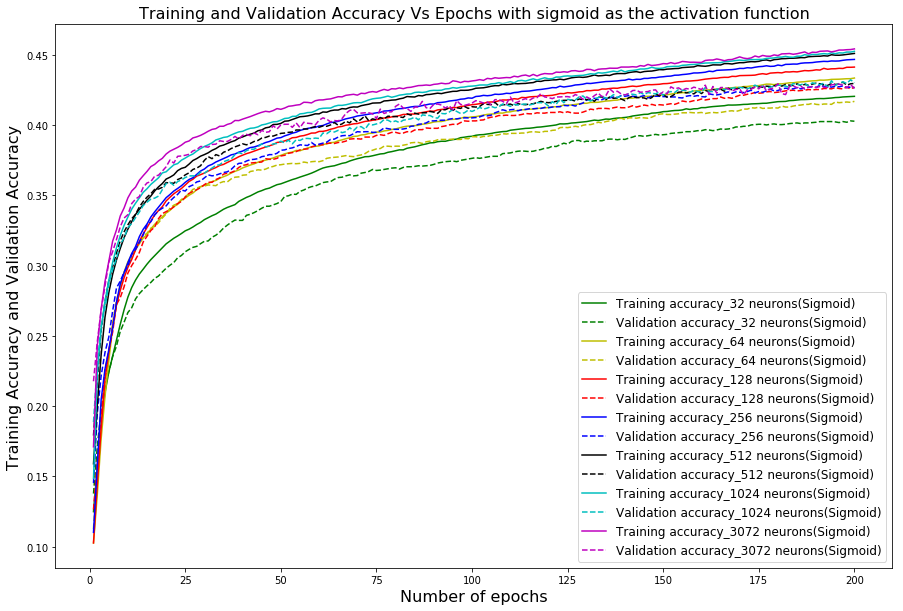

In [111]:
plt.figure(figsize = (15,10))
epoch=range(1,201)
plt.plot(epoch, hist_sig[0], 'g-', label = "Training accuracy_32 neurons(Sigmoid)")
plt.plot(epoch, hist_sig[2], 'g--', label = "Validation accuracy_32 neurons(Sigmoid)")
plt.plot(epoch, hist_sig[4], 'y-', label = "Training accuracy_64 neurons(Sigmoid)")
plt.plot(epoch, hist_sig[6], 'y--', label = "Validation accuracy_64 neurons(Sigmoid)")
plt.plot(epoch, hist_sig[8], 'r-', label = "Training accuracy_128 neurons(Sigmoid)")
plt.plot(epoch, hist_sig[10], 'r--', label = "Validation accuracy_128 neurons(Sigmoid)")
plt.plot(epoch, hist_sig[12], 'b-', label = "Training accuracy_256 neurons(Sigmoid)") 
plt.plot(epoch, hist_sig[14], 'b--', label = "Validation accuracy_256 neurons(Sigmoid)") 
plt.plot(epoch, hist_sig[16], 'k-', label = "Training accuracy_512 neurons(Sigmoid)")
plt.plot(epoch, hist_sig[18], 'k--', label = "Validation accuracy_512 neurons(Sigmoid)")
plt.plot(epoch, hist_sig[20], 'c-', label = "Training accuracy_1024 neurons(Sigmoid)")
plt.plot(epoch, hist_sig[22], 'c--', label = "Validation accuracy_1024 neurons(Sigmoid)")
plt.plot(epoch, hist_sig[24], 'm-', label = "Training accuracy_3072 neurons(Sigmoid)")
plt.plot(epoch, hist_sig[26], 'm--', label = "Validation accuracy_3072 neurons(Sigmoid)")
plt.xlabel('Number of epochs',fontsize=16)
plt.ylabel('Training Accuracy and Validation Accuracy',fontsize=16)
plt.title("Training and Validation Accuracy Vs Epochs with sigmoid as the activation function",fontsize=16)
plt.legend(fontsize=12)

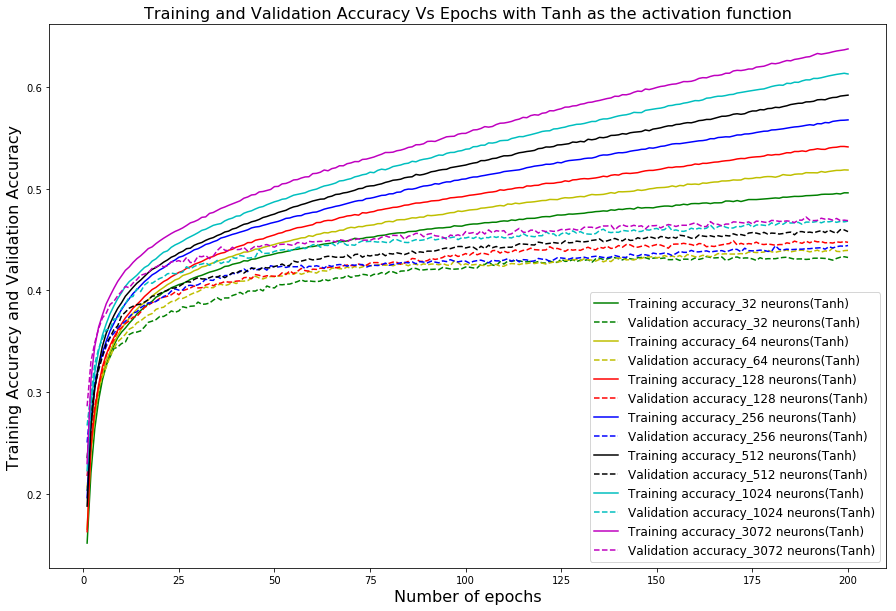

In [112]:
plt.figure(figsize = (15,10))
epoch=range(1,201)
plt.plot(epoch, hist_tanh[0], 'g-', label = "Training accuracy_32 neurons(Tanh)")
plt.plot(epoch, hist_tanh[2], 'g--', label = "Validation accuracy_32 neurons(Tanh)")
plt.plot(epoch, hist_tanh[4], 'y-', label = "Training accuracy_64 neurons(Tanh)")
plt.plot(epoch, hist_tanh[6], 'y--', label = "Validation accuracy_64 neurons(Tanh)")
plt.plot(epoch, hist_tanh[8], 'r-', label = "Training accuracy_128 neurons(Tanh)")
plt.plot(epoch, hist_tanh[10], 'r--', label = "Validation accuracy_128 neurons(Tanh)")
plt.plot(epoch, hist_tanh[12], 'b-', label = "Training accuracy_256 neurons(Tanh)") 
plt.plot(epoch, hist_tanh[14], 'b--', label = "Validation accuracy_256 neurons(Tanh)") 
plt.plot(epoch, hist_tanh[16], 'k-', label = "Training accuracy_512 neurons(Tanh)")
plt.plot(epoch, hist_tanh[18], 'k--', label = "Validation accuracy_512 neurons(Tanh)")
plt.plot(epoch, hist_tanh[20], 'c-', label = "Training accuracy_1024 neurons(Tanh)")
plt.plot(epoch, hist_tanh[22], 'c--', label = "Validation accuracy_1024 neurons(Tanh)")
plt.plot(epoch, hist_tanh[24], 'm-', label = "Training accuracy_3072 neurons(Tanh)")
plt.plot(epoch, hist_tanh[26], 'm--', label = "Validation accuracy_3072 neurons(Tanh)")
plt.xlabel('Number of epochs',fontsize=16)
plt.ylabel('Training Accuracy and Validation Accuracy',fontsize=16)
plt.title("Training and Validation Accuracy Vs Epochs with Tanh as the activation function",fontsize=16)
plt.legend(fontsize=12)

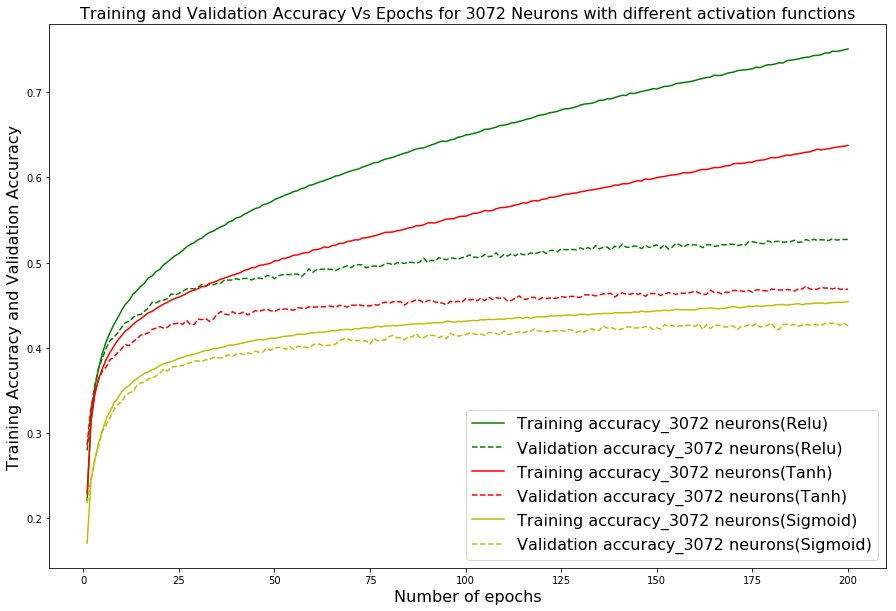

In [113]:
plt.figure(figsize = (15,10))
epoch=range(1,201)
plt.plot(epoch, hist[24], 'g-', label = "Training accuracy_3072 neurons(Relu)")
plt.plot(epoch, hist[26], 'g--', label = "Validation accuracy_3072 neurons(Relu)")
plt.plot(epoch, hist_tanh[24], 'r-', label = "Training accuracy_3072 neurons(Tanh)")
plt.plot(epoch, hist_tanh[26], 'r--', label = "Validation accuracy_3072 neurons(Tanh)")
plt.plot(epoch, hist_sig[24], 'y-', label = "Training accuracy_3072 neurons(Sigmoid)")
plt.plot(epoch, hist_sig[26], 'y--', label = "Validation accuracy_3072 neurons(Sigmoid)")
plt.xlabel('Number of epochs',fontsize=16)
plt.ylabel('Training Accuracy and Validation Accuracy',fontsize=16)
plt.title("Training and Validation Accuracy Vs Epochs for 3072 Neurons with different activation functions",fontsize=16)
plt.legend(fontsize=16)

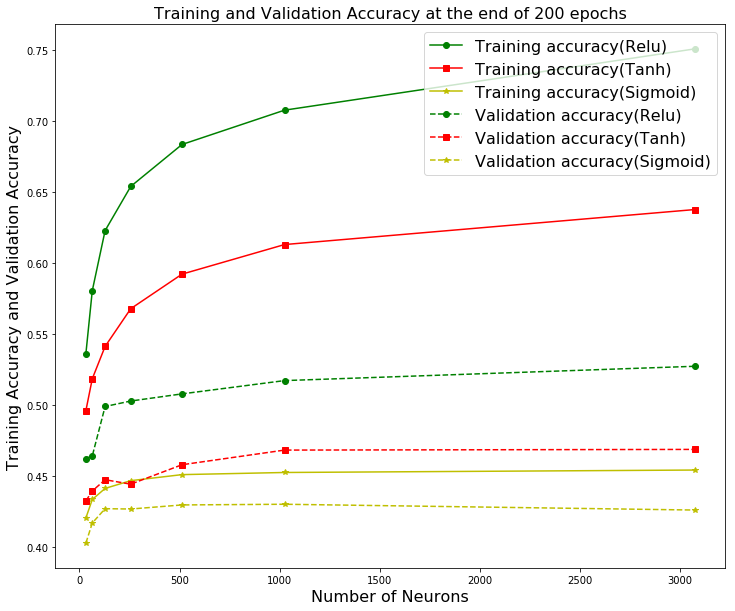

In [115]:
plt.figure(figsize = (12,10))
no_neurons = [32,64,128,256,512,1024,3072]
Acc_Relu = [hist[0][199],hist[4][199],hist[8][199],hist[12][199],hist[16][199],hist[20][199],hist[24][199]]
Acc_Tanh = [hist_tanh[0][199],hist_tanh[4][199],hist_tanh[8][199],hist_tanh[12][199],hist_tanh[16][199],hist_tanh[20][199],hist_tanh[24][199]]
Acc_Sig = [hist_sig[0][199],hist_sig[4][199],hist_sig[8][199],hist_sig[12][199],hist_sig[16][199],hist_sig[20][199],hist_sig[24][199]]
ValAcc_Relu = [hist[2][199],hist[6][199],hist[10][199],hist[14][199],hist[18][199],hist[22][199],hist[26][199]]
ValAcc_Tanh = [hist_tanh[2][199],hist_tanh[6][199],hist_tanh[10][199],hist_tanh[14][199],hist_tanh[18][199],hist_tanh[22][199],hist_tanh[26][199]]
ValAcc_Sig = [hist_sig[2][199],hist_sig[6][199],hist_sig[10][199],hist_sig[14][199],hist_sig[18][199],hist_sig[22][199],hist_sig[26][199]]
plt.plot(no_neurons, Acc_Relu, 'go-', label = "Training accuracy(Relu)")
plt.plot(no_neurons, Acc_Tanh, 'rs-', label = "Training accuracy(Tanh)")
plt.plot(no_neurons, Acc_Sig, 'y*-', label = "Training accuracy(Sigmoid)")
plt.plot(no_neurons, ValAcc_Relu, 'go--', label = "Validation accuracy(Relu)")
plt.plot(no_neurons, ValAcc_Tanh, 'rs--', label = "Validation accuracy(Tanh)")
plt.plot(no_neurons, ValAcc_Sig, 'y*--', label = "Validation accuracy(Sigmoid)")
plt.xlabel('Number of Neurons',fontsize=16)
plt.ylabel('Training Accuracy and Validation Accuracy',fontsize=16)
plt.title("Training and Validation Accuracy at the end of 200 epochs",fontsize=16)
plt.legend(fontsize=16)

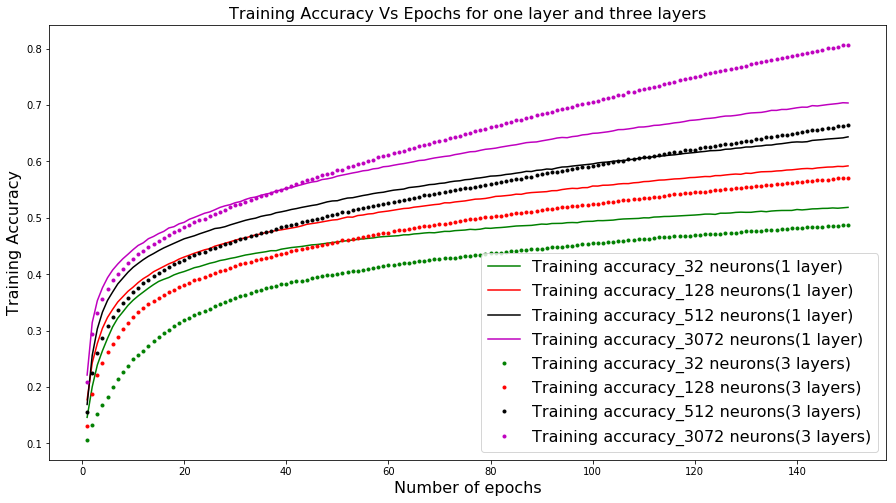

In [55]:
plt.figure(figsize = (15,8))
epoch=range(1,151)
plt.plot(epoch, hist[0][:150], 'g-', label = "Training accuracy_32 neurons(1 layer)")
plt.plot(epoch, hist[8][:150], 'r-', label = "Training accuracy_128 neurons(1 layer)")
plt.plot(epoch, hist[16][:150], 'k-', label = "Training accuracy_512 neurons(1 layer)")
plt.plot(epoch, hist[24][:150], 'm-', label = "Training accuracy_3072 neurons(1 layer)")

plt.plot(epoch, hist_layer3[0], 'g.', label = "Training accuracy_32 neurons(3 layers)")
plt.plot(epoch, hist_layer3[4], 'r.', label = "Training accuracy_128 neurons(3 layers)")
plt.plot(epoch, hist_layer3[8], 'k.', label = "Training accuracy_512 neurons(3 layers)")
plt.plot(epoch, hist_layer3[12], 'm.', label = "Training accuracy_3072 neurons(3 layers)")
plt.xlabel('Number of epochs',fontsize=16)
plt.ylabel('Training Accuracy',fontsize=16)
plt.title("Training Accuracy Vs Epochs for one layer and three layers",fontsize=16)
plt.legend(fontsize=16)

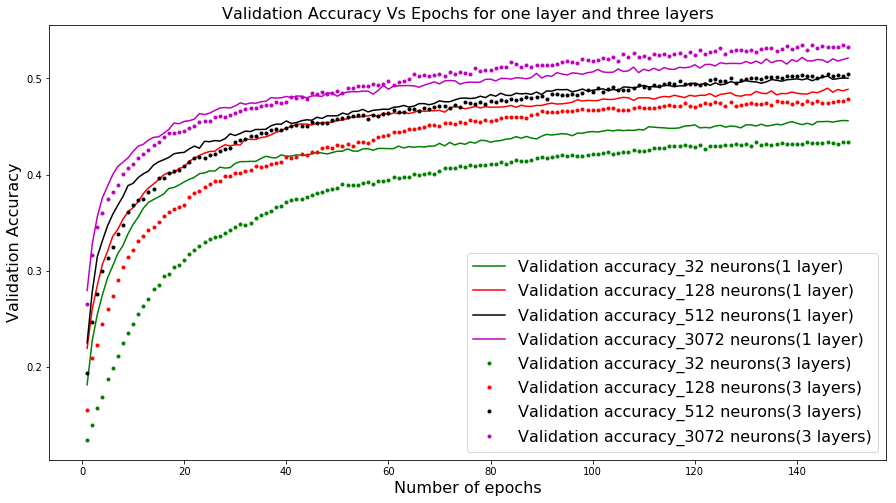

In [58]:
plt.figure(figsize = (15,8))
epoch=range(1,151)
plt.plot(epoch, hist[2][:150], 'g-', label = "Validation accuracy_32 neurons(1 layer)")
plt.plot(epoch, hist[10][:150], 'r-', label = "Validation accuracy_128 neurons(1 layer)")
plt.plot(epoch, hist[18][:150], 'k-', label = "Validation accuracy_512 neurons(1 layer)")
plt.plot(epoch, hist[26][:150], 'm-', label = "Validation accuracy_3072 neurons(1 layer)")

plt.plot(epoch, hist_layer3[2], 'g.', label = "Validation accuracy_32 neurons(3 layers)")
plt.plot(epoch, hist_layer3[6], 'r.', label = "Validation accuracy_128 neurons(3 layers)")
plt.plot(epoch, hist_layer3[10], 'k.', label = "Validation accuracy_512 neurons(3 layers)")
plt.plot(epoch, hist_layer3[14], 'm.', label = "Validation accuracy_3072 neurons(3 layers)")
plt.xlabel('Number of epochs',fontsize=16)
plt.ylabel('Validation Accuracy',fontsize=16)
plt.title("Validation Accuracy Vs Epochs for one layer and three layers",fontsize=16)
plt.legend(fontsize=16)

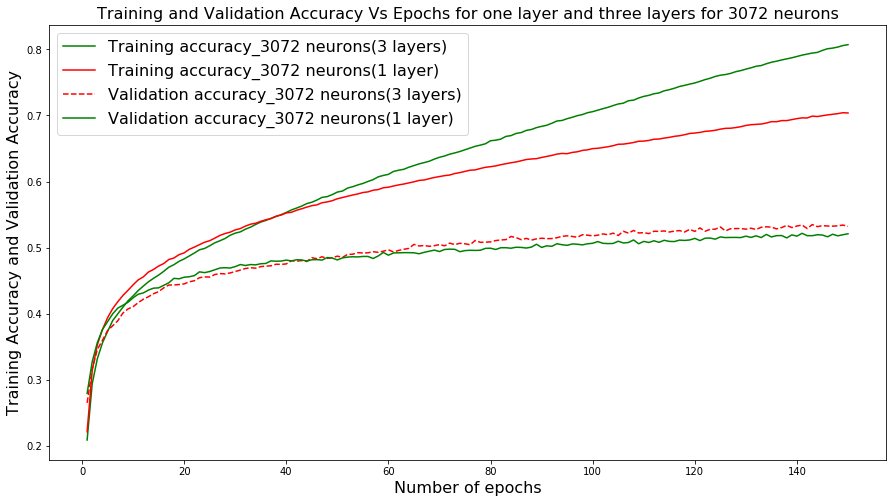

In [116]:
plt.figure(figsize = (15,8))
epoch=range(1,151)
plt.plot(epoch, hist_layer3[12], 'g-', label = "Training accuracy_3072 neurons(3 layers)")
plt.plot(epoch, hist[24][:150], 'r-', label = "Training accuracy_3072 neurons(1 layer)")
plt.plot(epoch, hist_layer3[14], 'r--', label = "Validation accuracy_3072 neurons(3 layers)")
plt.plot(epoch, hist[26][:150], 'g-', label = "Validation accuracy_3072 neurons(1 layer)")

plt.xlabel('Number of epochs',fontsize=16)
plt.ylabel('Training Accuracy and Validation Accuracy',fontsize=16)
plt.title("Training and Validation Accuracy Vs Epochs for one layer and three layers for 3072 neurons",fontsize=16)
plt.legend(fontsize=16)

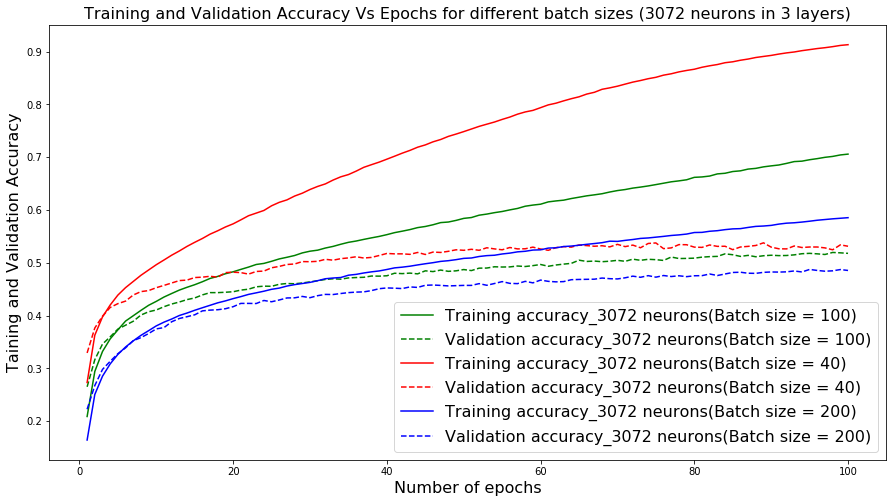

In [118]:
plt.figure(figsize = (15,8))
epoch=range(1,101)
plt.plot(epoch, hist_layer3[12][:100], 'g-', label = "Training accuracy_3072 neurons(Batch size = 100)")
plt.plot(epoch, hist_layer3[14][:100], 'g--', label = "Validation accuracy_3072 neurons(Batch size = 100)")

plt.plot(epoch, batch_size_hist[0], 'r-', label = "Training accuracy_3072 neurons(Batch size = 40)")
plt.plot(epoch, batch_size_hist[2], 'r--', label = "Validation accuracy_3072 neurons(Batch size = 40)")

plt.plot(epoch, batch_size_hist[4], 'b-', label = "Training accuracy_3072 neurons(Batch size = 200)")
plt.plot(epoch, batch_size_hist[6], 'b--', label = "Validation accuracy_3072 neurons(Batch size = 200)")

plt.xlabel('Number of epochs',fontsize=16)
plt.ylabel('Taining and Validation Accuracy',fontsize=16)
plt.title("Training and Validation Accuracy Vs Epochs for different batch sizes (3072 neurons in 3 layers)",fontsize=16)
plt.legend(fontsize=16)

# Retrieving the Best Model (3 Hidden layers, 3072 Neurons in each hidden layer, Batch size = 40)

In [74]:
from keras.models import load_model
Optimal_Model = load_model('model_info_batch_size_40')

# Checking if the right model is retrieved by testing with the Val loss and Accuracy

In [81]:
val_score = Optimal_Model.evaluate(X_val, Y_val)
print(val_score)

4167/4167 [==============================] - 11s    
[0.063454003495465719, 0.53131749462903988]


# Normalizing/Feature scaling of the test data

In [120]:
print(test_images1.shape)
X_test_unscaled =  np.resize(test_images1,(10000,3072))
X_test_scaled = scaler.fit_transform(X_test_unscaled.astype(np.float32))

(10000, 32, 32, 3)


# Evaluating the Model with Test data

In [121]:
test_score = Optimal_Model.evaluate(X_test_scaled, labels_test)
print(test_score)

10000/10000 [==============================] - 27s    
[0.063441971933841712, 0.5323]


# Predicting the output for the test data

In [122]:
y_test_predict = Optimal_Model.predict(X_test_scaled)

# Confusion Matrix

In [123]:
from sklearn.metrics import confusion_matrix
Confusion_Matrix_test = confusion_matrix(labels_test.argmax(axis=1),y_test_predict.argmax(axis=1)) 

In [124]:
print(Confusion_Matrix_test)

[[608  29  49  26  39  20  25  31 121  52]
 [ 44 605  25  28  17  12  24  27  73 145]
 [ 73  16 391 105 152  84  75  60  22  22]
 [ 25  19  67 377  84 204  98  57  31  38]
 [ 48  13 118  60 473  80  78  89  22  19]
 [ 19  12  73 199  86 450  47  68  20  26]
 [ 13  18  58 106 110  69 572  17  12  25]
 [ 40  12  44  71  71  81  17 604  12  48]
 [ 91  66  12  33  25  20  12  17 673  51]
 [ 36 165  12  43  21  23  26  51  53 570]]


In [125]:
import seaborn as sn
import matplotlib.pyplot as plt

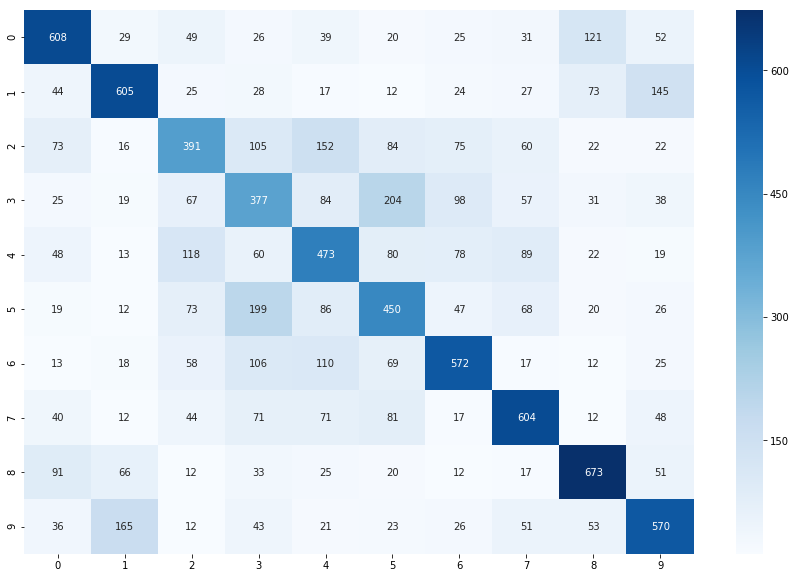

In [126]:
plt.figure(figsize = (15,10))
sn.heatmap(Confusion_Matrix_test, annot = True , fmt = 'd', cmap = 'Blues')

In [128]:
from sklearn.metrics import classification_report
print(classification_report(labels_test.argmax(axis=1),y_test_predict.argmax(axis=1)))

             precision    recall  f1-score   support

          0       0.61      0.61      0.61      1000
          1       0.63      0.60      0.62      1000
          2       0.46      0.39      0.42      1000
          3       0.36      0.38      0.37      1000
          4       0.44      0.47      0.46      1000
          5       0.43      0.45      0.44      1000
          6       0.59      0.57      0.58      1000
          7       0.59      0.60      0.60      1000
          8       0.65      0.67      0.66      1000
          9       0.57      0.57      0.57      1000

avg / total       0.53      0.53      0.53     10000

